DSS 740 \
Professor Chakravarty \
27 April 2025

Team Members:
- Brittney Bedrossian
- Breenda Shah
- Jeb Besecker
- Kevin Dennin
- Kohry Long


<h1> Final Project: Classification Model to Predict Loan Approval </h1>

<h2> Import packages and classes </h2>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

ModuleNotFoundError: No module named 'pandas'

<h2> Functions </h2>

In [5]:
def cm(y_pred, y_test, model=str, tuned=False, smote=False):
    """
    Creates the confusion matrix for the model and outputs the evaluation metrics

    Inputs:
    1. y_pred   :      Model predictions from test set
    2. y_test   :      Test set
    3.title     :      Name of the model -- Logistic Regression, SVM, Decision Tree
    4.tuned     :      Set to yes if the model was tuned. Default False
    5.smote     :      Set to yes if smote was applied to the data. Default False 
    """
    cm = confusion_matrix(y_test, y_pred)

    # Annotations for squares
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = [f'{value}' for value in cm.flatten()]
    labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
    labels = np.array(labels).reshape(2, 2)

    # Plot
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
   #plt.title(f"Confusion Matrix for {model}")
    if tuned==False and smote==False:
        plt.title(f"Confusion Matrix for {model}")
    elif tuned==True and smote==False:
        plt.title(f"Confusion Matrix for {model} (Tuned)")
    elif tuned==False and smote==True:
        plt.title(f"Confusion Matrix for {model} (Smote)")
    elif tuned==True and smote==True:
        plt.title(f"Confusion Matrix for {model} (Smote/Tuned)")
    plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
    plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
    plt.show()

    #Evaluate the model
    print("\n--- Model Evaluation ---")
    accuracyScore = accuracy_score(y_test, y_pred)
    precisionScore = precision_score(y_test, y_pred)
    recallScore = recall_score(y_test, y_pred)
    f1Score = f1_score(y_test, y_pred)

    print('Accuracy Score: ', accuracy_score(y_test, y_pred))
    print('Precision Score: ', precision_score(y_test, y_pred))
    print('Recall Score: ', recall_score(y_test, y_pred))
    print('F1 Score: ', f1_score(y_test, y_pred))

    tn = cm[0,0]
    fp = cm[0,1]
    specificity = tn/(tn+fp)
    print('Specificity: ', specificity)
    scores = [accuracyScore, precisionScore, recallScore, f1Score, specificity]

    return classification_report(y_test, y_pred)

def cm_Only(y_pred, y_test, model=str, tuned=False, smote=False):
    """
    Outputs the confusion matrix
    """
    cm = confusion_matrix(y_test, y_pred)

    # Annotations for squares
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = [f'{value}' for value in cm.flatten()]
    labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
    labels = np.array(labels).reshape(2, 2)

    # Plot
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
   #plt.title(f"Confusion Matrix for {model}")
    if tuned==False and smote==False:
        plt.title(f"Confusion Matrix for {model}")
    elif tuned==True and smote==False:
        plt.title(f"Confusion Matrix for {model} (Tuned)")
    elif tuned==False and smote==True:
        plt.title(f"Confusion Matrix for {model} (Smote)")
    elif tuned==True and smote==True:
        plt.title(f"Confusion Matrix for {model} (Smote/Tuned)")
    plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
    plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
    #plt.show()

    return cm

def cm_Scores(y_pred, y_test, cm):
    """
    Creates a dataframe with all of the scores calculated from the confusion matrix
    """
    accuracyScore = accuracy_score(y_test, y_pred)
    precisionScore = precision_score(y_test, y_pred)
    recallScore = recall_score(y_test, y_pred)
    f1Score = f1_score(y_test, y_pred)

    tn = cm[0,0]
    fp = cm[0,1]
    specificity = tn/(tn+fp)

    scores = {
        'Accuracy Score': accuracyScore,
        'Precision Score': precisionScore,
        'Recall Score': recallScore,
        'F1 Score': f1Score,
        'Specificity': specificity
    }

    scores_df = pd.DataFrame([scores])
    return scores_df

def decisionTree(model, X_train, tuned=False, smote=False):
    """
    Creates the decision tree visual
    1. model    :   Decision Tree model
    2. X_train  :   X train set
    3.tuned     :   Set to yes if the model was tuned. Default False
    4.smote     :   Set to yes if smote was applied to the data. Default False
    """
    plt.figure(figsize=(25, 12))  
    plot_tree(model,
            filled=True,
            rounded=True,
            feature_names=X_train.columns,
            class_names=['Rejected', 'Approved'],
            fontsize=12,
            impurity=False,       
            proportion=True)
    if tuned==False and smote==False:
        plt.title("Decision Tree - Loan Approval Prediction", fontsize=12)
    elif tuned==True and smote==False:
        plt.title("Decision Tree (Tuned) - Loan Approval Prediction", fontsize=12)
    elif tuned==False and smote==True:
        plt.title("Decision Tree (Smote) - Loan Approval Prediction", fontsize=12)
    elif tuned==True and smote==True:
        plt.title("Decision Tree (Smote/Tuned) - Loan Approval Prediction", fontsize=12)
    #plt.title("Decision Tree - Loan Approval Prediction", fontsize=12)
    plt.tight_layout()
    plt.show()

    return None

def plot_learning_curve(estimator, title, X, y, axes=None, train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring='accuracy'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.legend(loc="best")
    return plt

#  --- Hyperparameter Tuning Param Grids ---
# Logistic regression
lr_param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Decision tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}

# SVM Model
svm_param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10]
}

<h2> Changelog Intialization </h2>

In [6]:
# Initilize changelog
changelog = []

<h2> Data Load </h2>

In [7]:
# Load the dataset
df = pd.read_csv("../Data/loan_data.csv")
df.head()

person_age person_gender person_education  person_income  person_emp_exp  \
0          22        female           Master          71948               0   
1          21        female      High School          12282               0   
2          25        female      High School          12438               3   
3          23        female         Bachelor          79753               0   
4          24          male           Master          66135               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT      35000    PERSONAL          16.02   
1                   OWN       1000   EDUCATION          11.14   
2              MORTGAGE       5500     MEDICAL          12.87   
3                  RENT      35000     MEDICAL          15.23   
4                  RENT      35000     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                           3           561   
1                 0.08                           2           504   
2                 0.44                           3           635   
3                 0.44                           2           675   
4                 0.53                           4           586   

  previous_loan_defaults_on_file  loan_status  
0                             No            1  
1                            Yes            0  
2                             No            1  
3                             No            1  
4                             No            1

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  int64  
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  int64  
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  int64  
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  int64  
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [9]:
# Intial Stats of numerical variables
df.describe()

person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   4.500000e+04    45000.000000  45000.000000   
mean      27.764178   8.031905e+04        5.410333   9583.157556   
std        6.045108   8.042250e+04        6.063532   6314.886691   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.720400e+04        1.000000   5000.000000   
50%       26.000000   6.704800e+04        4.000000   8000.000000   
75%       30.000000   9.578925e+04        8.000000  12237.250000   
max      144.000000   7.200766e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000             0.070000                    3.000000   
50%        11.010000             0.120000                    4.000000   
75%        12.990000             0.190000                    8.000000   
max        20.000000             0.660000                   30.000000   

       credit_score   loan_status  
count  45000.000000  45000.000000  
mean     632.608756      0.222222  
std       50.435865      0.415744  
min      390.000000      0.000000  
25%      601.000000      0.000000  
50%      640.000000      0.000000  
75%      670.000000      0.000000  
max      850.000000      1.000000

**Initial observations of the numerical variables** - The dataset contains 45,000 records and provides insights into individuals' demographics, income, employment experience, and loan-related details. The average age of individuals is approximately 27.76 years, with a minimum of 20 and a maximum of 144 years, suggesting a likely data outlier at the upper end. Similarly, the person_income variable has a mean of about $80,319, but a maximum value of over $7.2 million indicates the presence of extreme outliers. Employment experience (person_emp_exp) averages around 5.41 years, though the maximum value of 125 years is likely unrealistic and could also be an error. Loan amounts range from $500 to $35,000, with a mean of approximately $9,583, while interest rates vary from 5.42% to 20%, averaging around 11%. The loan_percent_income, which represents the loan amount as a proportion of income, has a mean of 0.14. Credit history length and credit scores also show considerable variation, with the average credit score being 632 and ranging from 390 to 850. Lastly, the loan_status variable indicates that around 22% of individuals in the dataset received loan approval. Overall, the data shows strong variability, and several features may require cleaning or normalization due to the presence of clear outliers.

In [10]:
# Intial Stats of categorical variables
df.describe(include = object)

person_gender person_education person_home_ownership loan_intent  \
count          45000            45000                 45000       45000   
unique             2                5                     4           6   
top             male         Bachelor                  RENT   EDUCATION   
freq           24841            13399                 23443        9153   

       previous_loan_defaults_on_file  
count                           45000  
unique                              2  
top                               Yes  
freq                            22858

**Initial observation of categorical variables** - the majority of the population is male, accounting for 24,841 entries. Education levels are diverse, with five unique categories, and the most common qualification is a Bachelor’s degree, held by 13,399 individuals. When it comes to housing status, renting is the most frequent form of home ownership, with 23,443 individuals reporting it. The dataset also records loan intentions, with six distinct purposes, of which education-related loans are the most common, making up 9,153 entries. Lastly, the variable indicating whether individuals had previous loan defaults shows an almost even split, with 22,858 people having a history of loan defaults.

<Axes: >

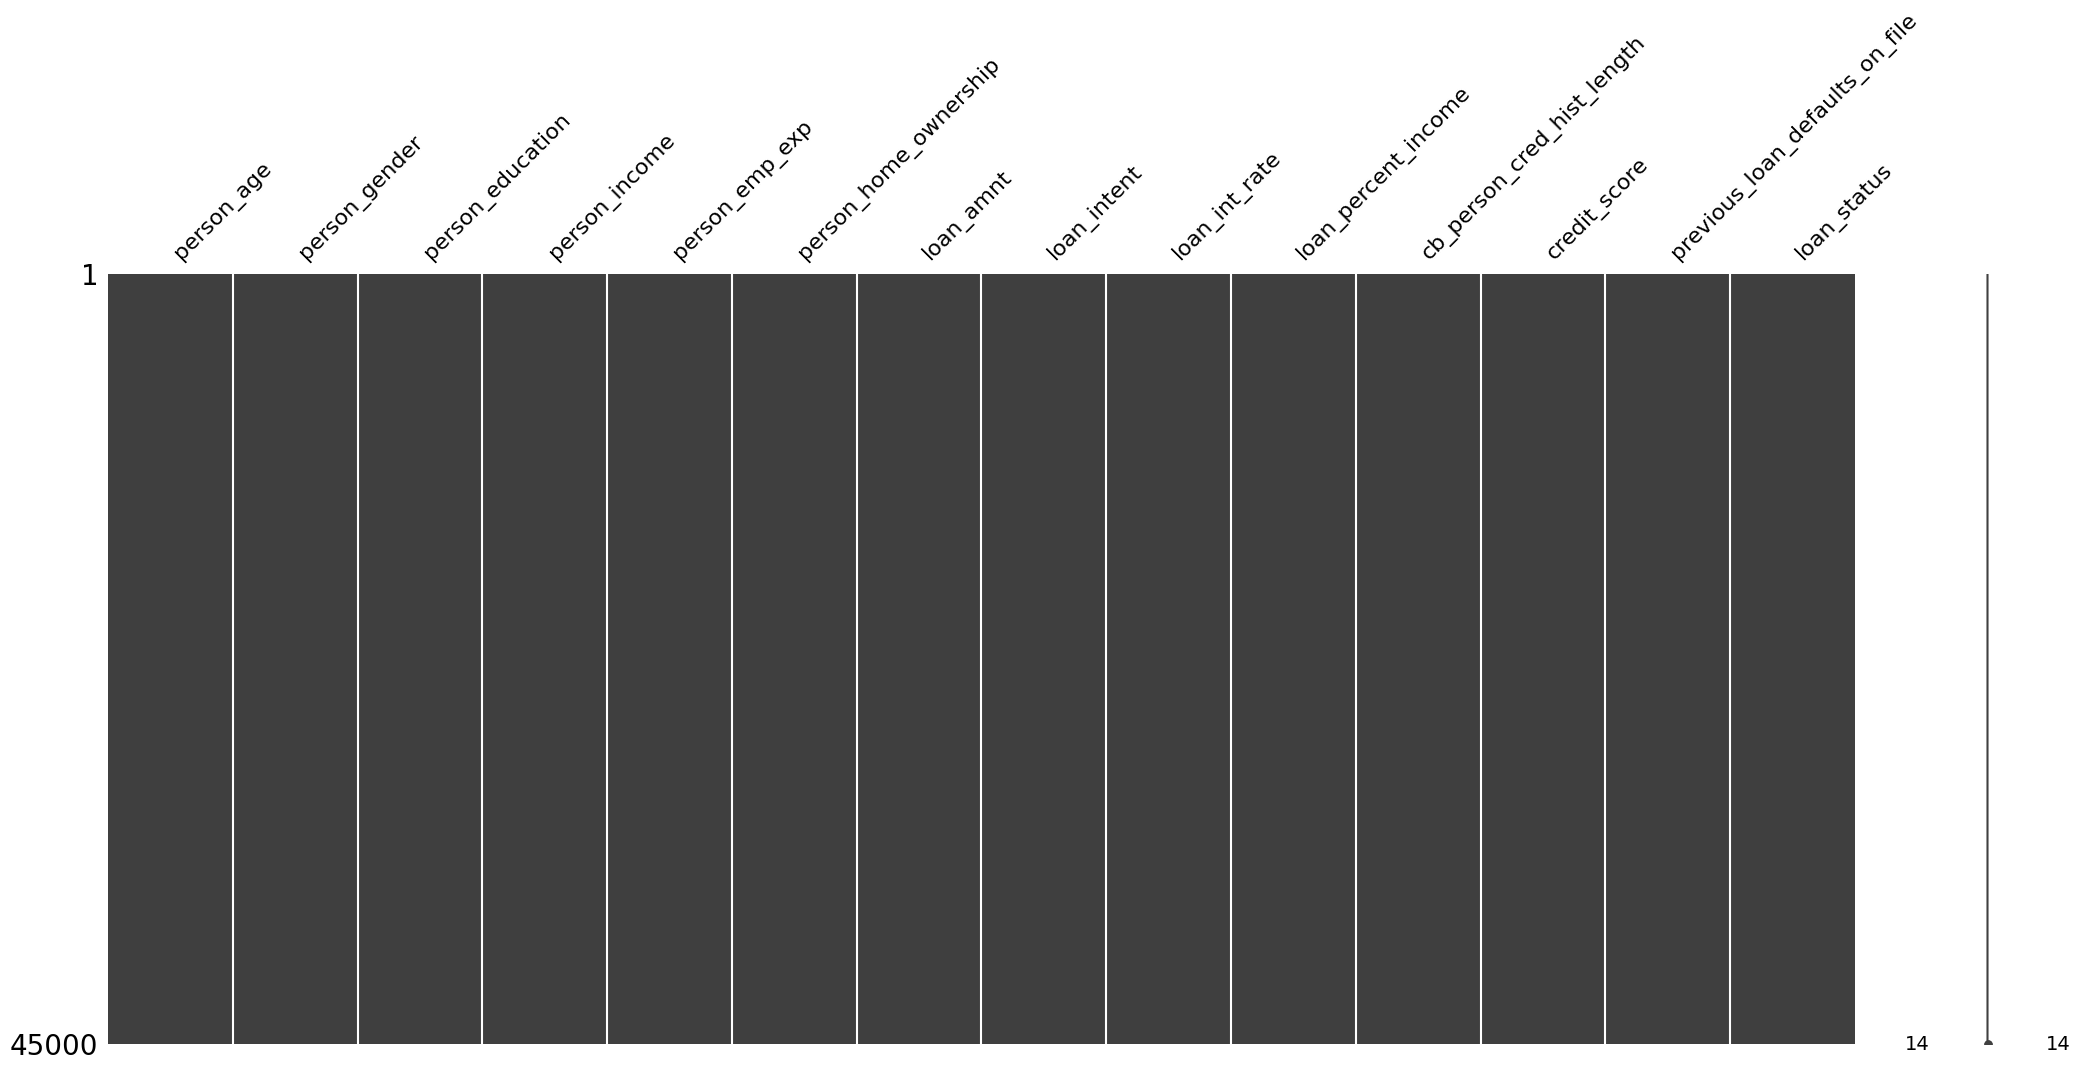

In [11]:
# Explore MissingNo
mno.matrix(df)

<h2> Data Exploration </h2>

<h3> Categorical Analysis </h3>

In [12]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_columns)

Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


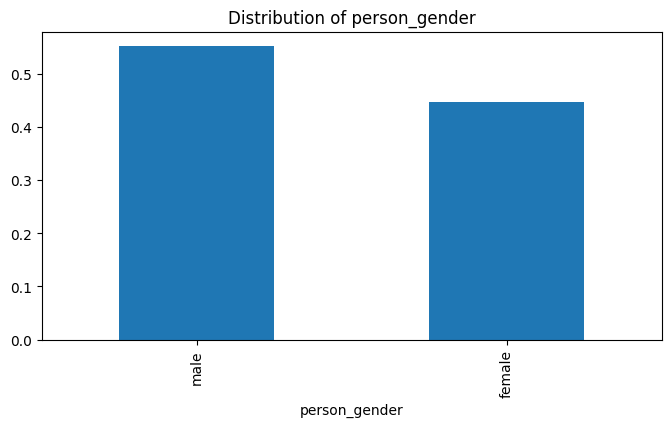

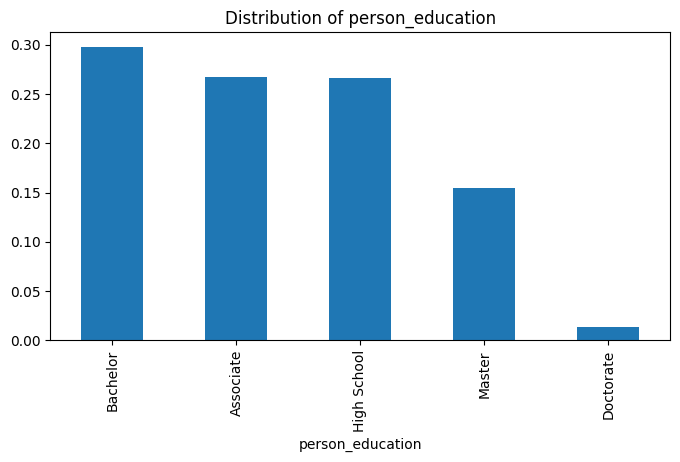

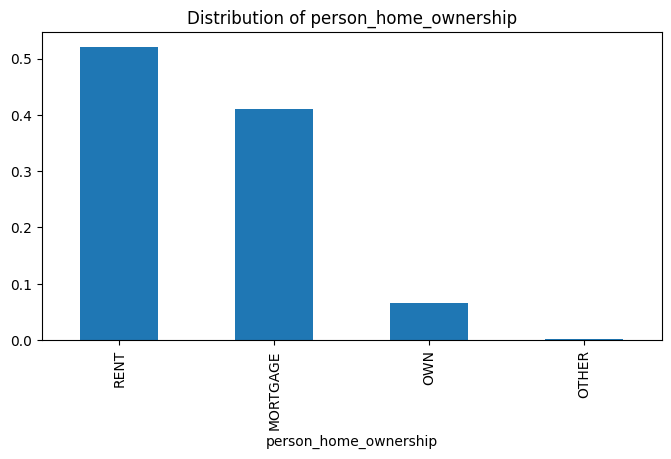

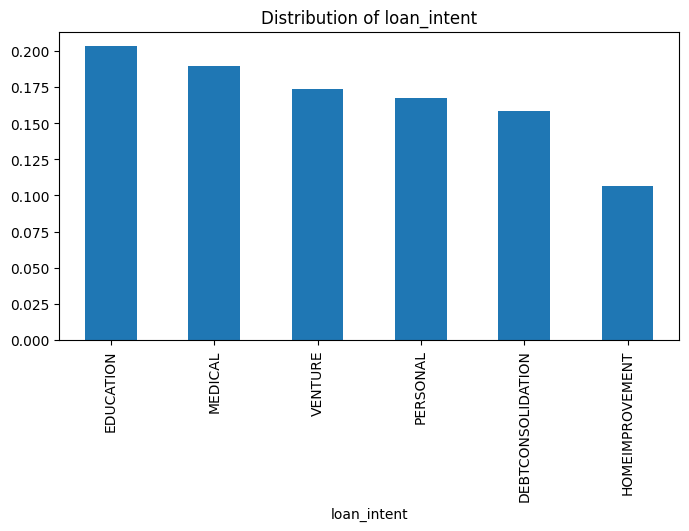

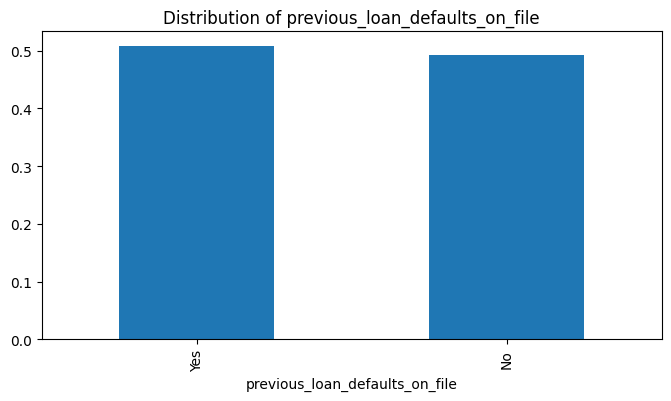

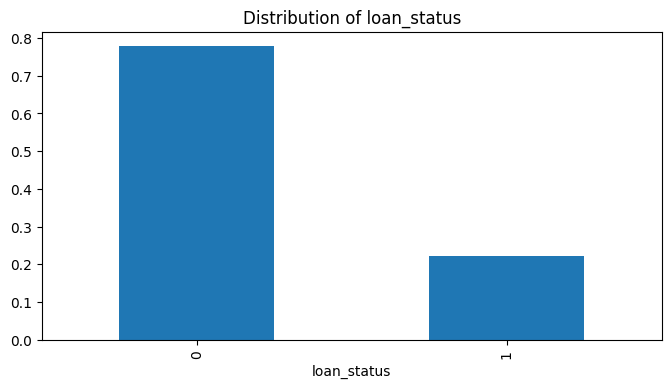

In [13]:
# Univariate analysis of categorical variables
for col in categorical_columns + ['loan_status']:
    fig = plt.figure(figsize=(8, 4))
    df[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.show()

Firstly, there are no spelling errors present in the dataset. Secondly, given that the "Own" and "Other" categories constitute a small proportion of the person_home_ownership variable, it may be appropriate to consolidate them into a single "Others" category for more effective analysis. Lastly, the overall distribution of the remaining categorical variables appears well-balanced. However, an exception is observed in the person_education variable, where the "Doctorate" group represents a notably small subset of the population - consider dropping this all together. 

<h3> Numerical Analysis </h3>

Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


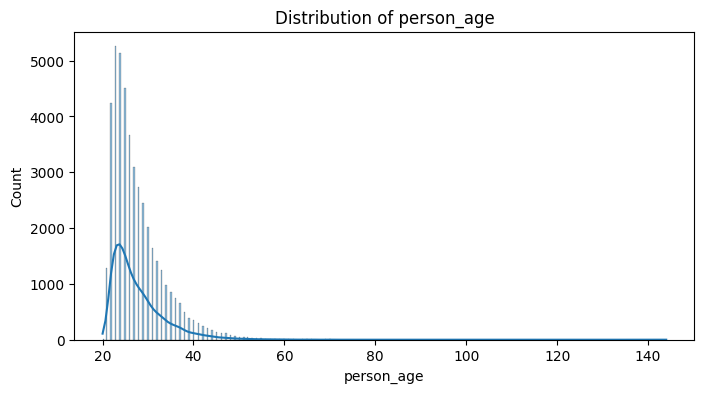

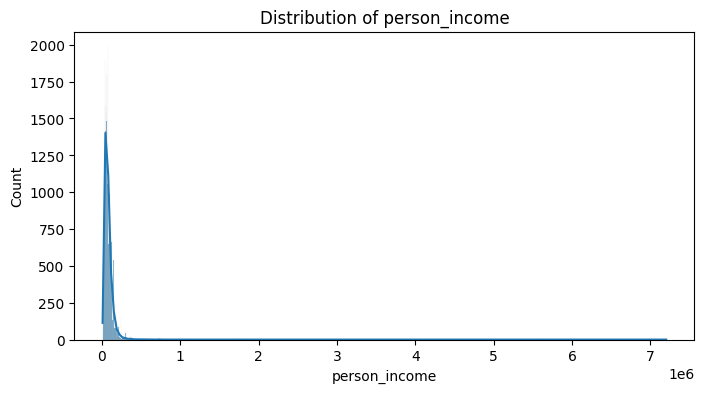

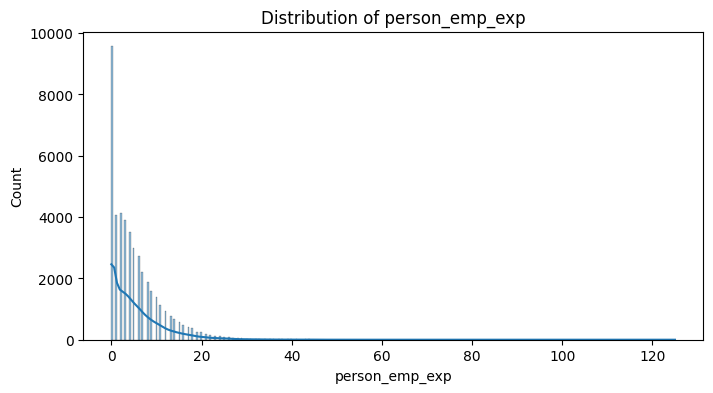

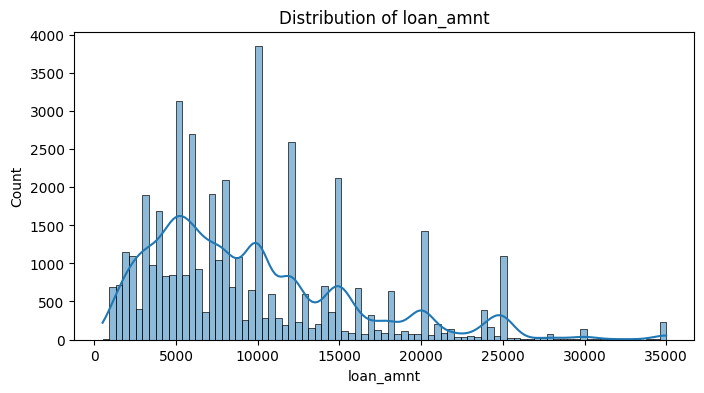

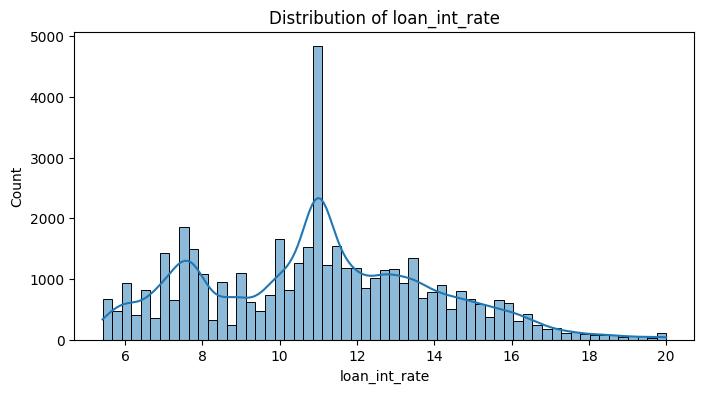

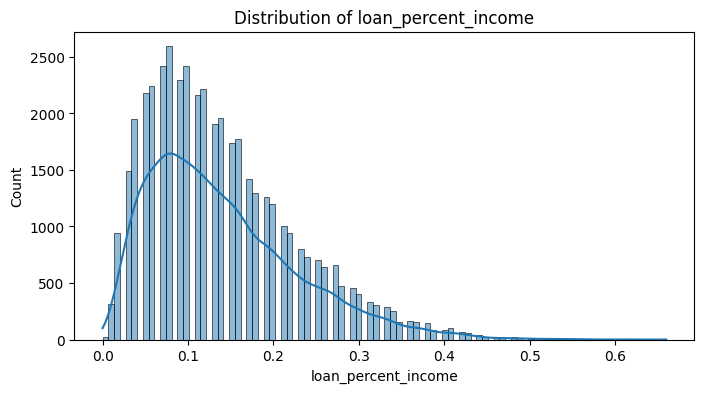

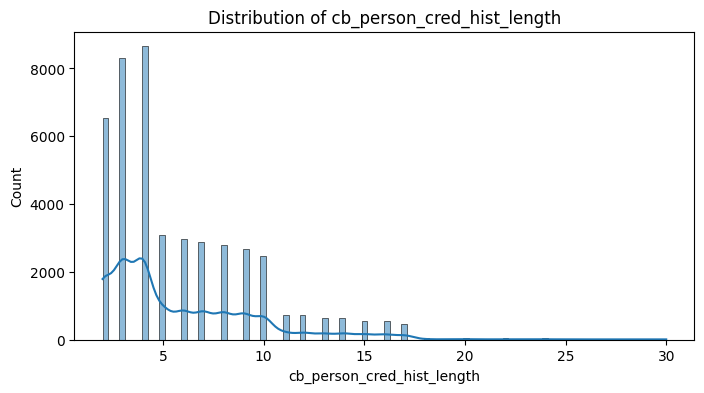

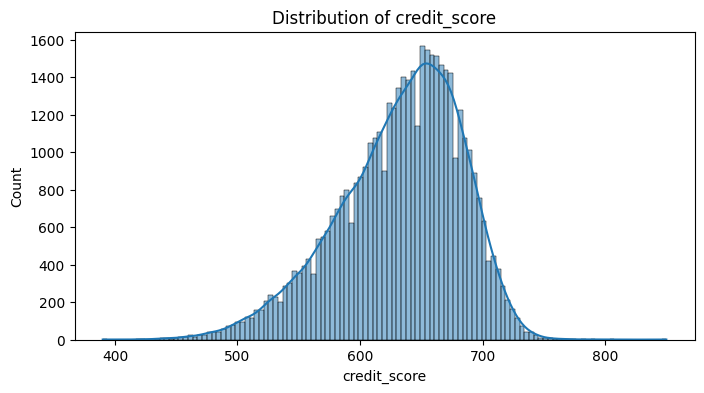

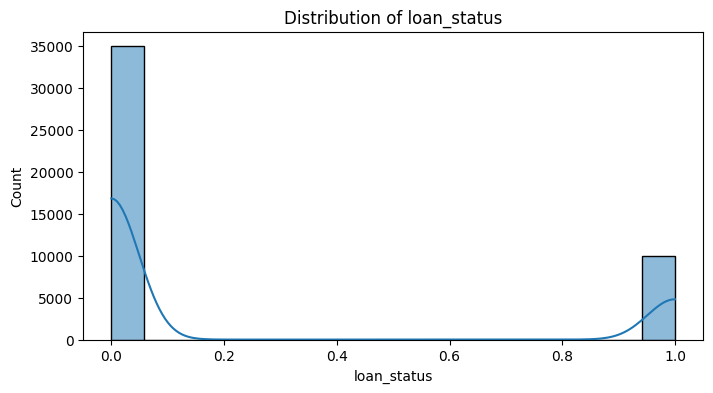

In [14]:
# Univariate analysis of numerical variables
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", numerical_columns)
for col in numerical_columns:
    fig = plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [15]:
# Checking for skewness in each of the numerical variables
numericalColumns = df.select_dtypes(include=[ 'int64'])
numericalColumns[:10]              

#Checking for skewness in the numerical columns.
skewness = df[numericalColumns.columns].skew()
print(skewness)

person_age                     2.548154
person_income                 34.137583
person_emp_exp                 2.594917
loan_amnt                      1.179731
cb_person_cred_hist_length     1.631720
credit_score                  -0.610261
loan_status                    1.336351
dtype: float64


The skewness results for the numerical variables indicate that several distributions are significantly non-normal, with a strong tendency toward right skewness. Notably, person_income shows an extreme right skew (skewness = 34.14), suggesting the presence of a few individuals with very high incomes that distort the overall distribution. Similarly, person_age and person_emp_exp both exhibit strong right skewness (2.55 and 2.59, respectively), likely influenced by outliers such as individuals with unusually high age or employment experience values as mentioned earlier in summary stats. The loan_amnt and cb_person_cred_hist_length variables also display moderate right skewness, indicating that most applicants request lower loan amounts and have relatively short credit histories. In contrast, credit_score shows a moderate left skew (-0.61), suggesting a concentration of higher credit scores with fewer individuals having poor credit. Lastly, the loan_status variable is moderately right-skewed (1.34), reflecting an imbalance in loan approvals versus rejections, which may require attention during classification tasks. 

<h2> Check for correlation and multicollinearity </h2>

<h3> Correlation </h3>

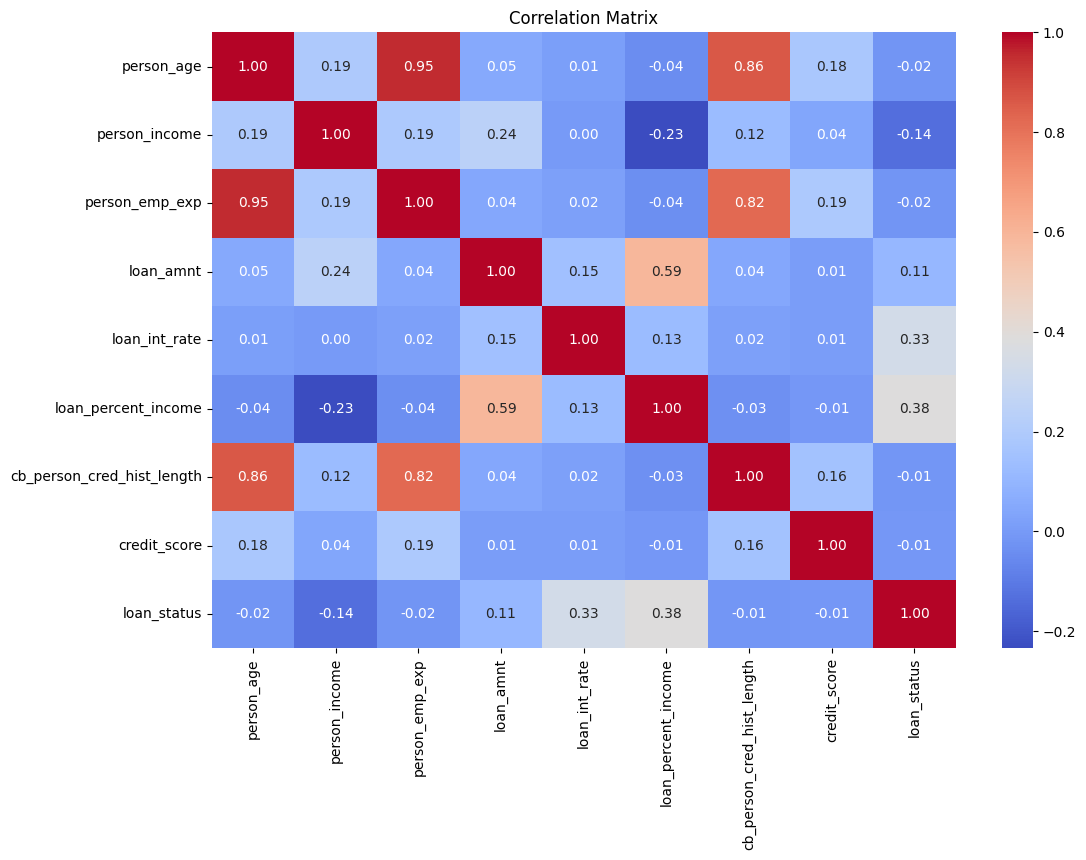

In [16]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Strong positive correlations: person_age and person_emp_exp (0.95): Older individuals tend to have more work experience, person_age and cb_person_cred_hist_length (0.86): Older applicants generally have longer credit histories, and person_emp_exp and cb_person_cred_hist_length (0.82): More experienced individuals also tend to have longer credit histories.

Moderate correlations:loan_amnt and loan_percent_income (0.59): Larger loan amounts typically make up a higher percentage of a person’s income, loan_status and loan_percent_income (0.38): Applicants with a higher loan-to-income ratio are more likely to be rejected, and loan_status and loan_int_rate (0.33): Higher interest rates are moderately associated with loan rejection.

Weak or negligible correlations:loan_status has weak correlation with most features, including person_age, person_income, person_emp_exp, and credit_score and person_income shows very little correlation with other variables, except a slight negative correlation with loan_percent_income (-0.23).

<h3> Multicollinearity </h3>

                      Feature       VIF
1               person_income  1.430818
2              person_emp_exp  3.229168
3                   loan_amnt  2.040333
4               loan_int_rate  1.024794
5         loan_percent_income  2.019054
6  cb_person_cred_hist_length  3.134232
7                credit_score  1.036041


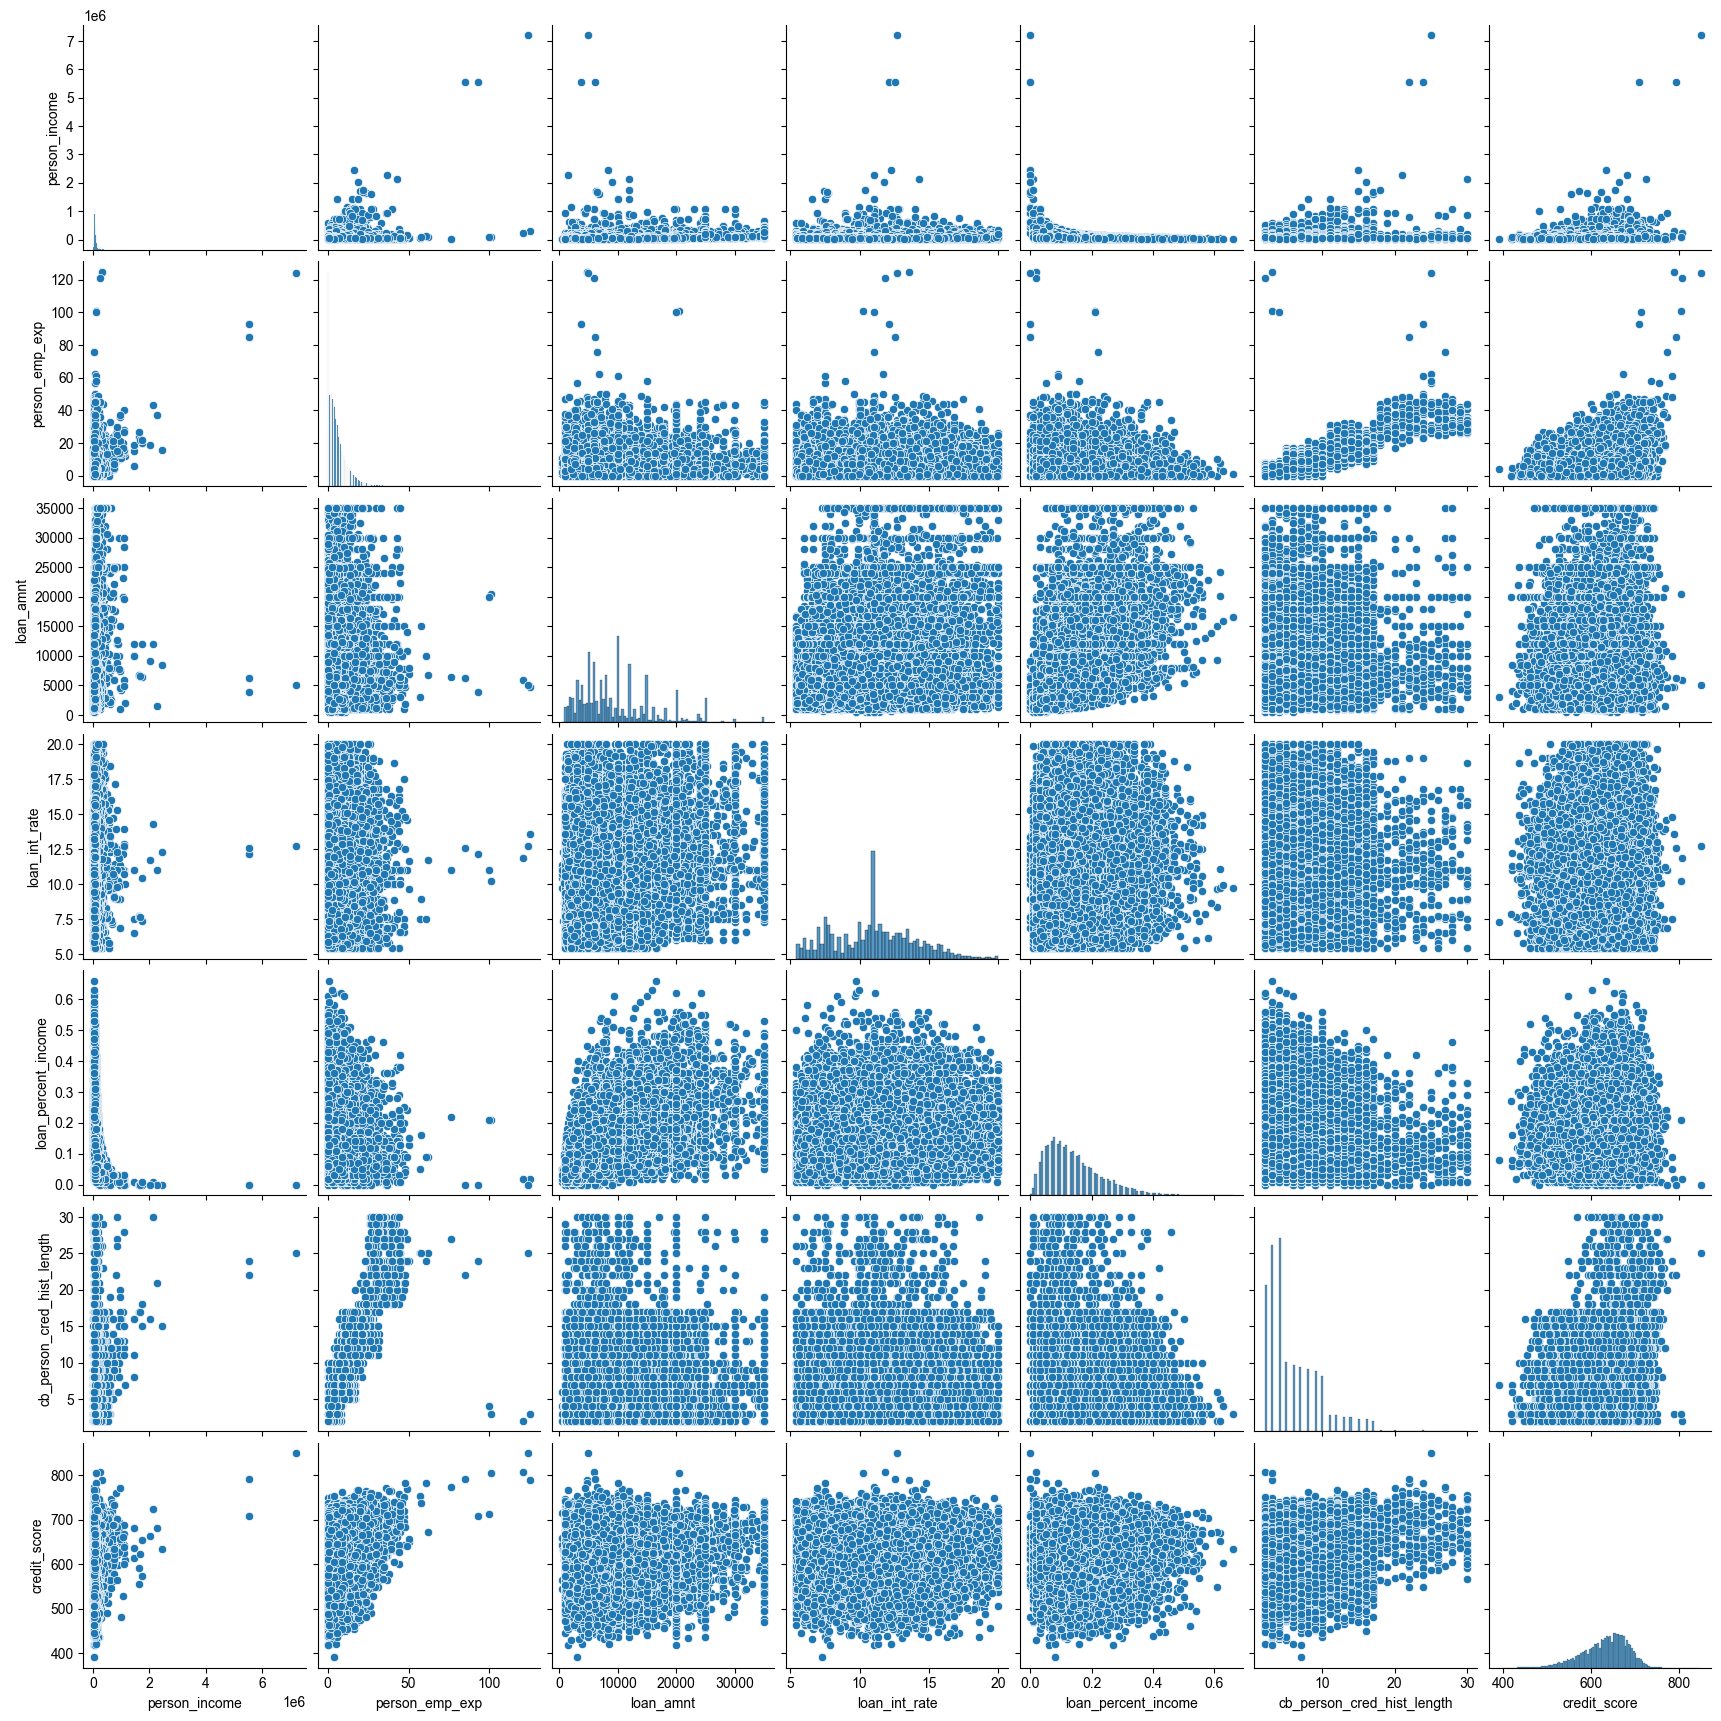

In [17]:
num_cols = ['person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length','credit_score']

# Subset the numerical columns
X = df[num_cols].copy()

# Add constant term for VIF calculation (intercept)
X_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Drop constant term (intercept) from results for clarity
vif_data = vif_data[vif_data["Feature"] != "const"]

print(vif_data)

#Pair plot of numerical columns
numerical_vars = ['person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length','credit_score']
sns.pairplot(df[numerical_vars])
sns.set_style("whitegrid")
plt.show()

The Variance Inflation Factor (VIF) analysis indicates that there is no significant multicollinearity among the selected numerical features in the dataset. All VIF values fall well below the common threshold of 5, suggesting that none of the variables are excessively correlated with one another. Specifically, variables such as person_income, loan_int_rate, and credit_score exhibit very low VIF values, confirming their independence from the other predictors. While person_emp_exp and cb_person_cred_hist_length show moderately higher VIFs around 3, these values are still within acceptable limits and do not pose a concern. Overall, the dataset's numerical features are suitable for use  without the risk of multicollinearity distorting the results. Additionally, the par plot between the numerical columns further suggest no significant relationship amongst the columns. 

<h2> Data Cleaning & Preprocessing </h2>

In [18]:
# Copy original df to df_cleaned
df_cleaned = df.copy()

In [19]:
# Remove unrealistic ages
original_row_count = df_cleaned.shape[0]
df_cleaned = df_cleaned[df_cleaned['person_age'] <= 125]
removed_count = original_row_count - df_cleaned.shape[0]


changelog.append({
    'column': 'age',
    'change': f'Removed {removed_count} row(s) where age > 125',
    'rationale': 'Oldest verified human lived to be 122; values above 125 are likely errors or outliers.',
})


In [20]:
# Drop loan_status column
df_cleaned.drop(columns=['loan_status'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
changelog.append({
    'column': 'loan_status',
    'change': 'Dropped loan_status column',
    'rationale': 'Target variable for classification; not needed in cleaned dataset.',
})


Numerical columns after capping: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


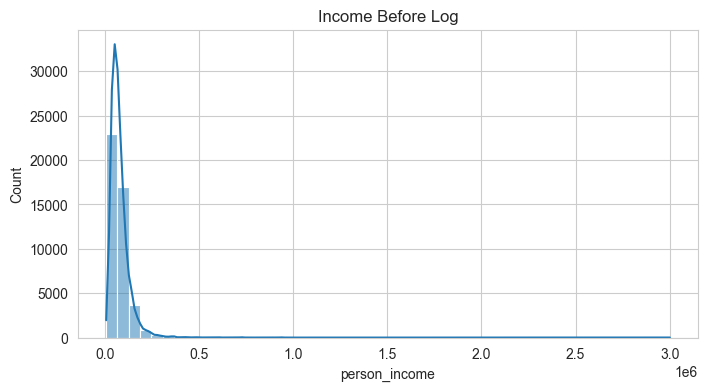

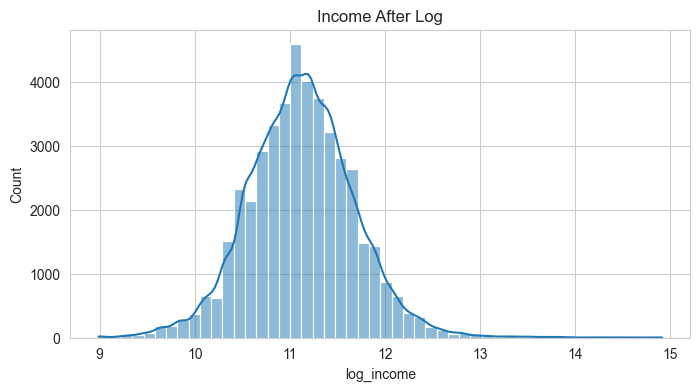

In [21]:
# Cap outliers before log-transform
df_cleaned['person_income'] = np.where(df_cleaned['person_income'] > 3_000_000, 3_000_000, df_cleaned['person_income'])


# Show numerical columns after capping
print("Numerical columns after capping:", numerical_columns)


# Apply log1p to preserve 0s and small values
df_cleaned['log_income'] = np.log1p(df_cleaned['person_income'])
changelog.append({
    'column': 'person_income',
    'change': 'Capped person_income at $3,000,000 and applied log1p transformation',
    'rationale': 'Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.',
})


plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['person_income'], bins=50, kde=True)
plt.title("Income Before Log")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['log_income'], bins=50, kde=True)
plt.title("Income After Log")
plt.show()


In [22]:
# Drop person_income after log-transform
df_cleaned.drop(columns=['person_income'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()


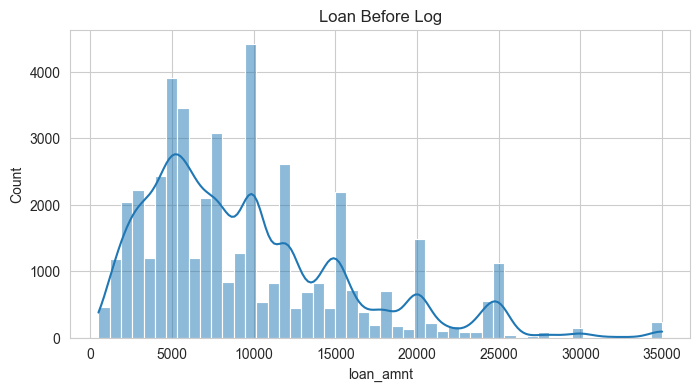

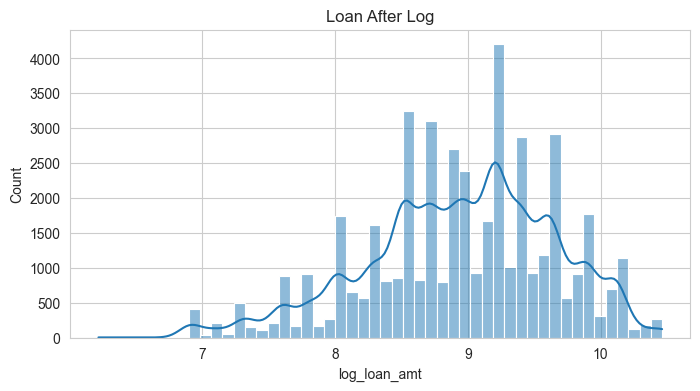

In [23]:
# Apply log1p to preserve 0s and small values
df_cleaned['log_loan_amt'] = np.log1p(df_cleaned['loan_amnt'])
changelog.append({
    'column': 'loan_amnt',
    'change': 'Applied log1p transformation to loan_amount',
    'rationale': 'Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.',
})

plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['loan_amnt'], bins=50, kde=True)
plt.title("Loan Before Log")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['log_loan_amt'], bins=50, kde=True)
plt.title("Loan After Log")
plt.show()

In [24]:
# Drop loan_amnt after log-transform
df_cleaned.drop(columns=['loan_amnt'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

In [25]:
# Remove unrealistic person_emp_exp values
original_row_count = df_cleaned.shape[0]
df_cleaned = df_cleaned[df_cleaned['person_emp_exp'] <= 70]
removed_count = original_row_count - df_cleaned.shape[0]
changelog.append({
    'column': 'person_emp_exp',
    'change': f'Removed {removed_count} row(s) where person_emp_exp > 70',
    'rationale': 'Unrealistic employment experience; values above 70 years are likely errors or outliers.',
}) 

<class 'pandas.core.frame.DataFrame'>
Index: 44992 entries, 0 to 44996
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      44992 non-null  int64  
 1   person_gender                   44992 non-null  object 
 2   person_education                44992 non-null  object 
 3   person_emp_exp                  44992 non-null  int64  
 4   person_home_ownership           44992 non-null  object 
 5   loan_intent                     44992 non-null  object 
 6   loan_int_rate                   44992 non-null  float64
 7   loan_percent_income             44992 non-null  float64
 8   cb_person_cred_hist_length      44992 non-null  int64  
 9   credit_score                    44992 non-null  int64  
 10  previous_loan_defaults_on_file  44992 non-null  object 
 11  log_income                      44992 non-null  float64
 12  log_loan_amt                    44992

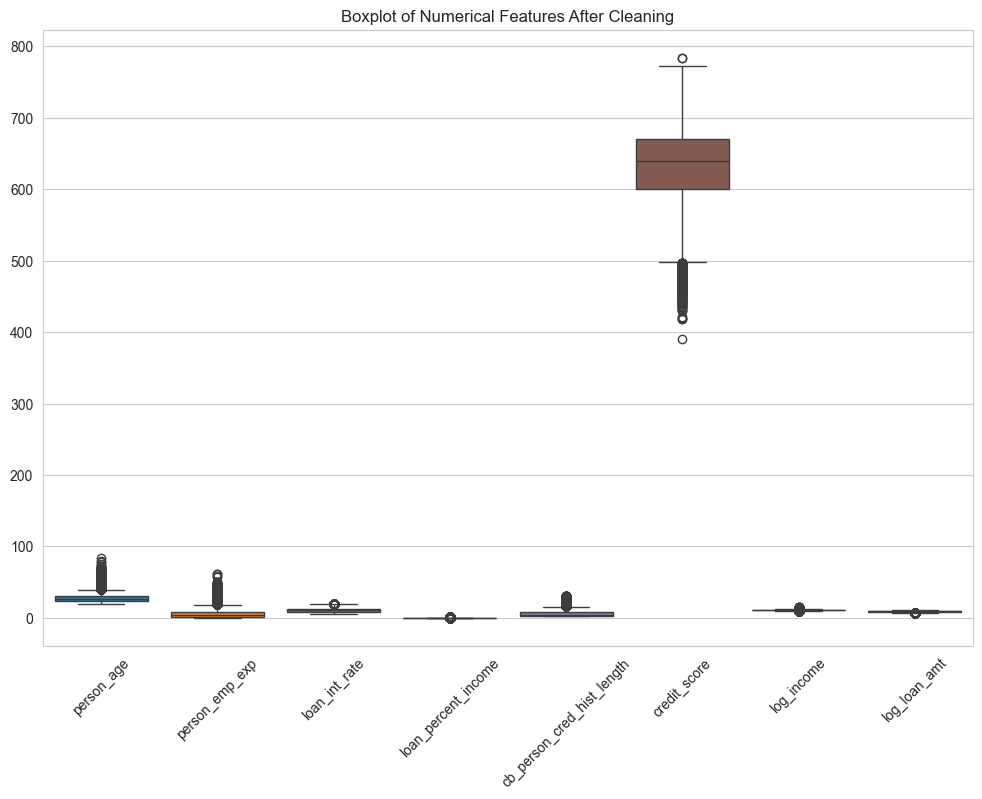

In [26]:
# Check cleaned data
df_cleaned.info()
df_cleaned.describe()

# Plot boxplot for cleaned data
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned[numerical_columns])
plt.title('Boxplot of Numerical Features After Cleaning')
plt.xticks(rotation=45)
plt.show()

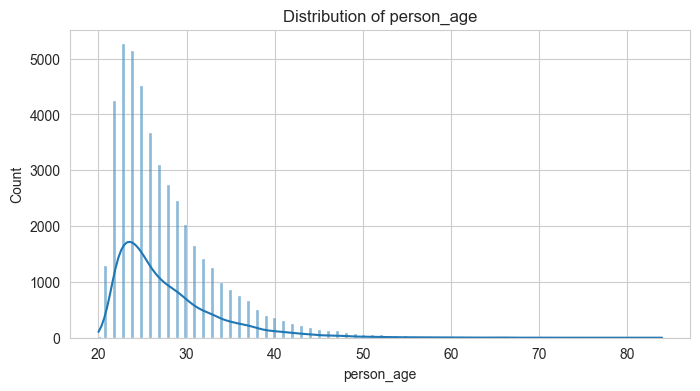

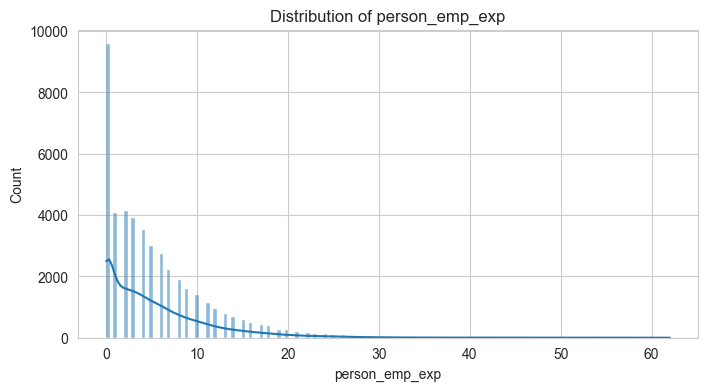

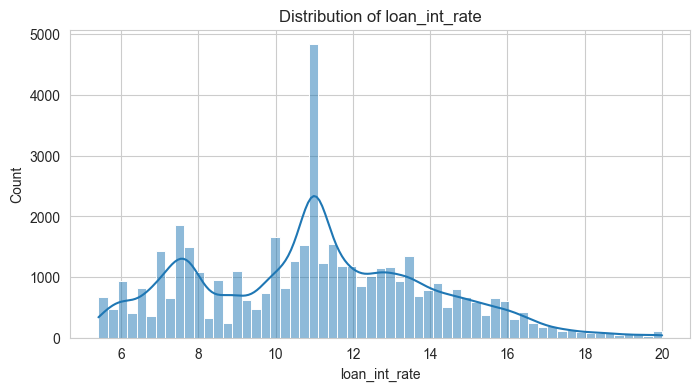

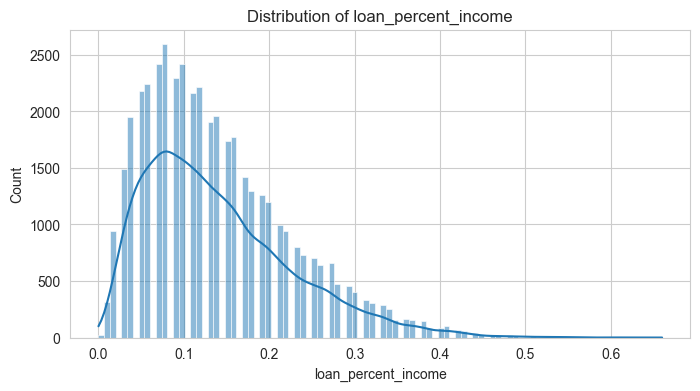

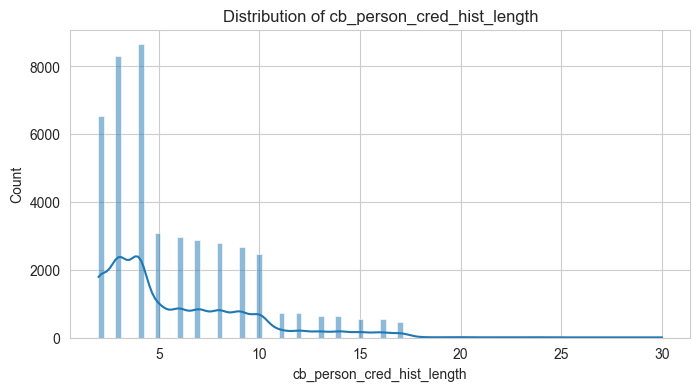

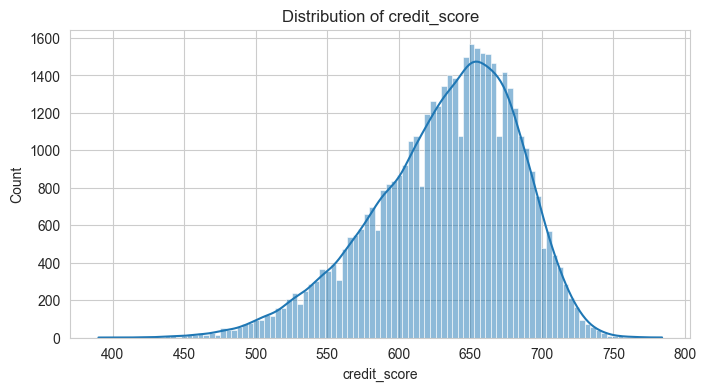

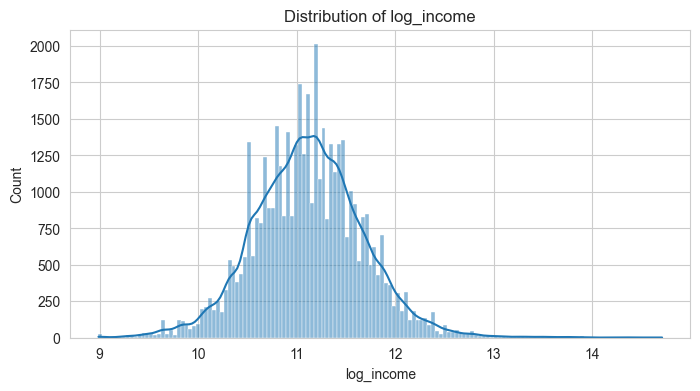

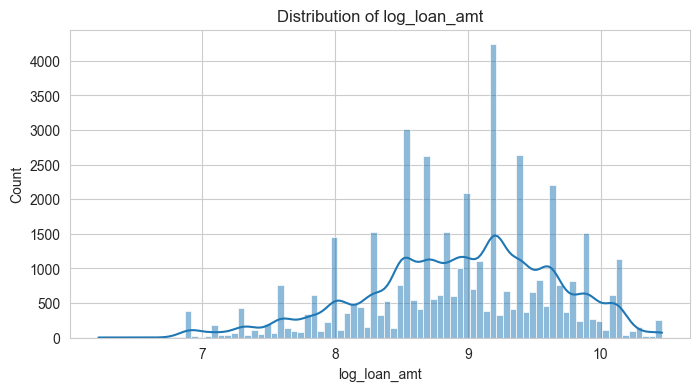

In [27]:
# Plot histogram for cleaned data
for col in numerical_columns:
    fig = plt.figure(figsize=(8, 4))
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


In [28]:
# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

column  \
0             age   
1     loan_status   
2   person_income   
3       loan_amnt   
4  person_emp_exp   

                                                                change  \
0                                     Removed 3 row(s) where age > 125   
1                                           Dropped loan_status column   
2  Capped person_income at $3,000,000 and applied log1p transformation   
3                          Applied log1p transformation to loan_amount   
4                           Removed 5 row(s) where person_emp_exp > 70   

                                                                                                                                   rationale  
0                                                     Oldest verified human lived to be 122; values above 125 are likely errors or outliers.  
1                                                                         Target variable for classification; not needed in cleaned dataset.  
2  Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.  
3                                    Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.  
4                                                    Unrealistic employment experience; values above 70 years are likely errors or outliers.

<class 'pandas.core.frame.DataFrame'>
Index: 44992 entries, 0 to 44996
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      44992 non-null  int64  
 1   person_gender                   44992 non-null  object 
 2   person_education                44992 non-null  object 
 3   person_emp_exp                  44992 non-null  int64  
 4   person_home_ownership           44992 non-null  object 
 5   loan_intent                     44992 non-null  object 
 6   loan_int_rate                   44992 non-null  float64
 7   loan_percent_income             44992 non-null  float64
 8   cb_person_cred_hist_length      44992 non-null  int64  
 9   credit_score                    44992 non-null  int64  
 10  previous_loan_defaults_on_file  44992 non-null  object 
 11  log_income                      44992 non-null  float64
 12  log_loan_amt                    44992

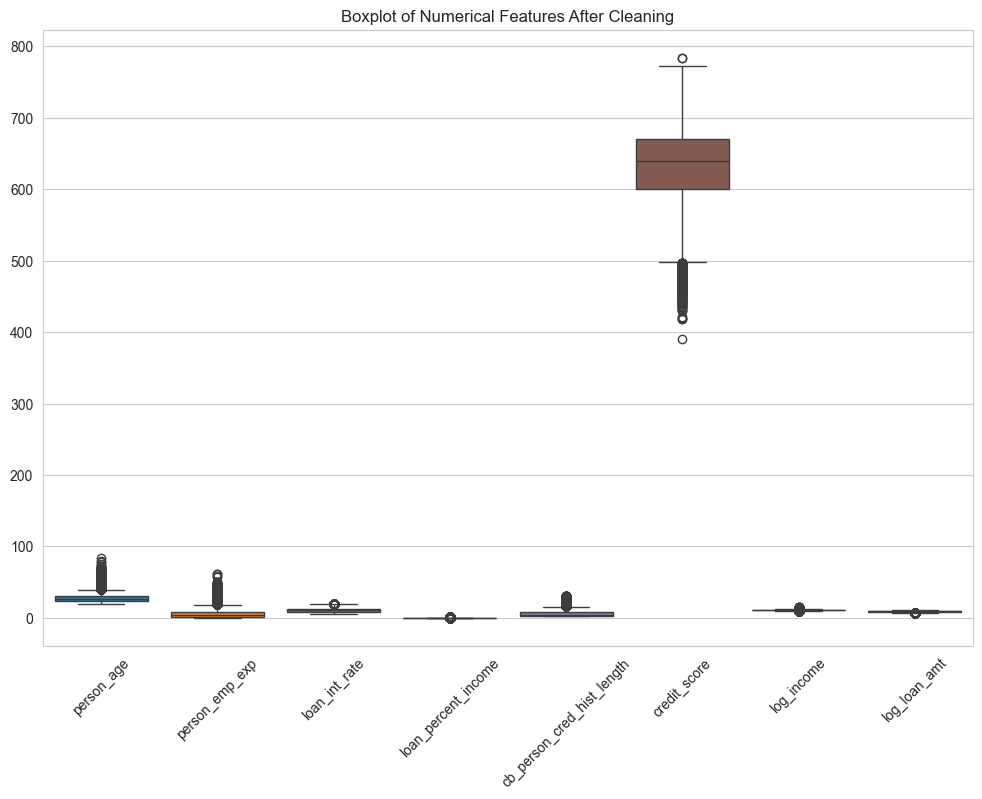

In [29]:
# Check cleaned data
df_cleaned.info()
df_cleaned.describe()

# Plot boxplot for cleaned data
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned[numerical_columns])
plt.title('Boxplot of Numerical Features After Cleaning')
plt.xticks(rotation=45)
plt.show()

<h2> Feature Engineering </h2>

<h5>  Education Variable </h5>

Since *Master* and *Doctorate* degrees are both Graduate degrees, we can combine those two categories into one and rename as *Graduate*, since the *Doctorate* category has a very low frequency compared to the others.

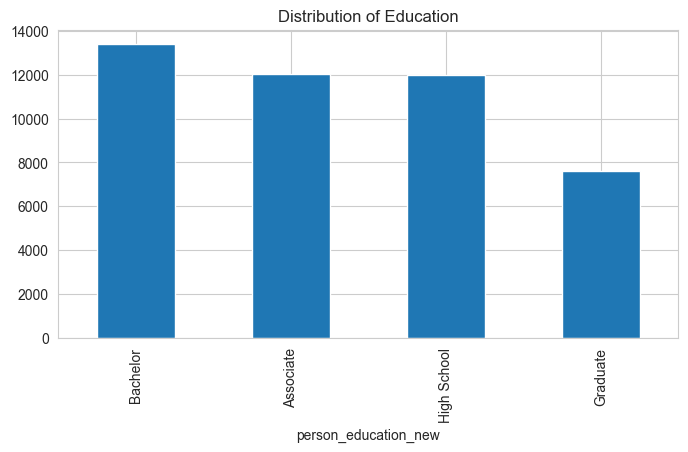

Number of records:  117


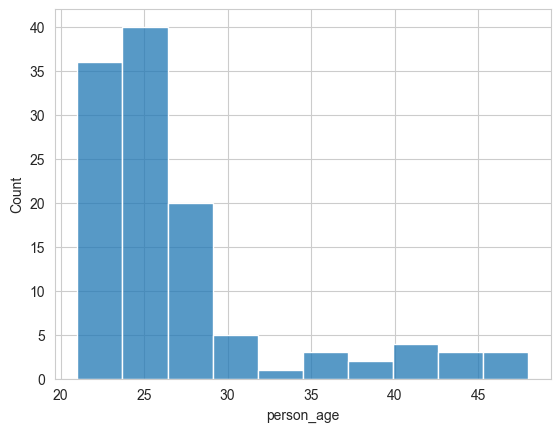

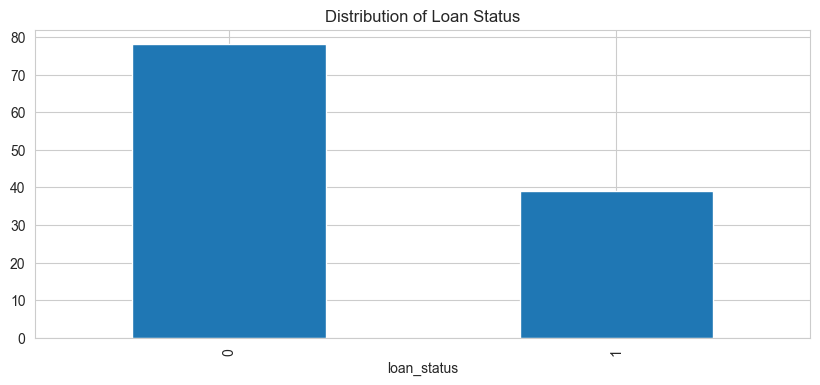

In [30]:
# Create the new mappings
grad_edu = {'Master': 'Graduate',
            'Doctorate': 'Graduate'
}

#Create new field with the updated values
df_cleaned['person_education_new'] = df['person_education'].replace(grad_edu)

#View the new distribution for education
fig = plt.figure(figsize=(8, 4))
df_cleaned['person_education_new'].value_counts().plot(kind='bar')
plt.title(f"Distribution of Education")
plt.show()

#Drop the original field
df_cleaned.drop('person_education', axis=1, inplace=True)

#Update the change log
changelog.append({
    'column': 'person_education',
    'change': 'Combined Master and Doctorate categories into one group -- Graduate',
    'rationale': 'Doctorate had the lowest frequency out of all the categories which could impact analysis',
})

#Create dataframe to hold the subset of data
other_home_ownership = df[df['person_home_ownership'] == 'OTHER']
#Find the number of records that fall into this subset
print("Number of records: ", len(other_home_ownership))

other_home_ownership.describe(include='all')


#Look at the distribution for age
sns.histplot(other_home_ownership['person_age'], bins=10)

#Look at the distribution for loan amount
fig = plt.figure(figsize=(10, 4))
other_home_ownership['loan_status'].value_counts().plot(kind='bar')
plt.title(f"Distribution of Loan Status")
plt.show()



<h3> Home Ownership Variable </h3>

Since the *Rent* and *Mortgage* categories have high frequencies and *Own* and *Other* have lower frequencies, we can combine them into two groups *Homeowner* and *Non-Homeowner*. *Rent* and *Other* would fall under *Non-Homeowner** and *Mortgage* and *Own* would fall until *Homeowner*.

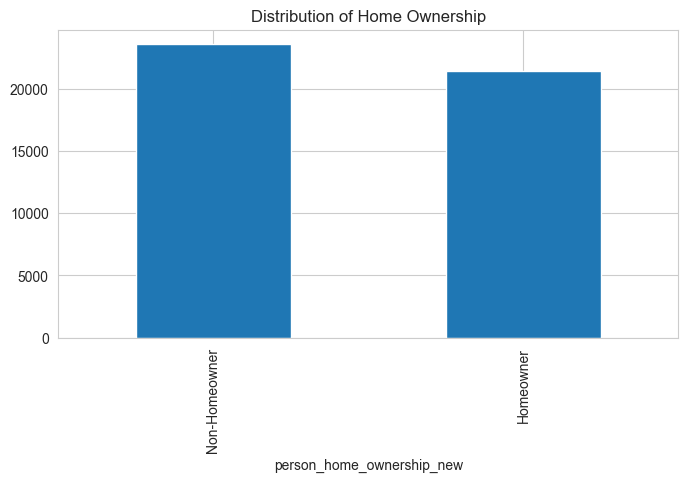

In [31]:
#Mapping for new categories
ownership = {'RENT': 'Non-Homeowner',
             'OTHER': 'Non-Homeowner',
             'MORTGAGE': 'Homeowner',
             'OWN': 'Homeowner'
}

#Create new field with the updated values
df_cleaned['person_home_ownership_new'] = df['person_home_ownership'].replace(ownership)

#View the new distribution
fig = plt.figure(figsize=(8, 4))
df_cleaned['person_home_ownership_new'].value_counts().plot(kind='bar')
plt.title(f"Distribution of Home Ownership")
plt.show()

#Drop the original field
df_cleaned.drop('person_home_ownership', axis=1, inplace=True)


In [32]:
#Update the change log
changelog.append({
    'column': 'person_home_ownership',
    'change': 'Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category',
    'rationale': 'RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis',
})

In [33]:
# Reinitialize categorical columns
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_columns)

Categorical columns: ['person_gender', 'loan_intent', 'previous_loan_defaults_on_file', 'person_education_new', 'person_home_ownership_new']


In [34]:
# Apply one-hot encoding to existing categorical_columns
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True, dtype=int)

# Review structure of df_cleaned after encoding
df_cleaned.info()

# Add to changelog
changelog.append({
    'column': categorical_columns,
    'change': 'Applied one-hot encoding (drop_first=True)',
    'rationale': 'Converted categorical variables into binary indicators for model compatibility.',
})


<class 'pandas.core.frame.DataFrame'>
Index: 44992 entries, 0 to 44996
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   person_age                               44992 non-null  int64  
 1   person_emp_exp                           44992 non-null  int64  
 2   loan_int_rate                            44992 non-null  float64
 3   loan_percent_income                      44992 non-null  float64
 4   cb_person_cred_hist_length               44992 non-null  int64  
 5   credit_score                             44992 non-null  int64  
 6   log_income                               44992 non-null  float64
 7   log_loan_amt                             44992 non-null  float64
 8   person_gender_male                       44992 non-null  int64  
 9   loan_intent_EDUCATION                    44992 non-null  int64  
 10  loan_intent_HOMEIMPROVEMENT              44992 non-

In [35]:
# Readd target variable
df_cleaned['loan_status'] = df['loan_status']

# Changelog for readding target variable
changelog.append({
    'column': 'loan_status',
    'change': 'Readded loan_status column',
    'rationale': 'Target variable for classification; readded after cleaning and preprocessing.',
})

In [36]:
# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

column  \
0                                                                                                            age   
1                                                                                                    loan_status   
2                                                                                                  person_income   
3                                                                                                      loan_amnt   
4                                                                                                 person_emp_exp   
5                                                                                               person_education   
6                                                                                          person_home_ownership   
7  [person_gender, loan_intent, previous_loan_defaults_on_file, person_education_new, person_home_ownership_new]   
8                                                                                                    loan_status   

                                                                                             change  \
0                                                                  Removed 3 row(s) where age > 125   
1                                                                        Dropped loan_status column   
2                               Capped person_income at $3,000,000 and applied log1p transformation   
3                                                       Applied log1p transformation to loan_amount   
4                                                        Removed 5 row(s) where person_emp_exp > 70   
5                               Combined Master and Doctorate categories into one group -- Graduate   
6  Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category   
7                                                        Applied one-hot encoding (drop_first=True)   
8                                                                        Readded loan_status column   

                                                                                                                                   rationale  
0                                                     Oldest verified human lived to be 122; values above 125 are likely errors or outliers.  
1                                                                         Target variable for classification; not needed in cleaned dataset.  
2  Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.  
3                                    Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.  
4                                                    Unrealistic employment experience; values above 70 years are likely errors or outliers.  
5                                                   Doctorate had the lowest frequency out of all the categories which could impact analysis  
6                                 RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis  
7                                                            Converted categorical variables into binary indicators for model compatibility.  
8                                                              Target variable for classification; readded after cleaning and preprocessing.

<h3> Export the Change Log and Cleaned Data to csv files </h3>

In [37]:
# Export Change Summary to CSV
change_summary.to_csv("../Changelogs/change_summary.csv", index=False)

In [38]:
# Export cleaned data
df_cleaned.to_csv("../Data/cleaned_loan_data.csv", index=False)
print("Cleaned data exported to cleaned_loan_data.csv")

Cleaned data exported to cleaned_loan_data.csv


<h2> Re-load the data </h2>

In [39]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary initialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

column  \
0                                                                                                                      age   
1                                                                                                              loan_status   
2                                                                                                            person_income   
3                                                                                                                loan_amnt   
4                                                                                                           person_emp_exp   
5                                                                                                         person_education   
6                                                                                                    person_home_ownership   
7  ['person_gender', 'loan_intent', 'previous_loan_defaults_on_file', 'person_education_new', 'person_home_ownership_new']   
8                                                                                                              loan_status   

                                                                                             change  \
0                                                                  Removed 3 row(s) where age > 125   
1                                                                        Dropped loan_status column   
2                               Capped person_income at $3,000,000 and applied log1p transformation   
3                                                       Applied log1p transformation to loan_amount   
4                                                        Removed 5 row(s) where person_emp_exp > 70   
5                               Combined Master and Doctorate categories into one group -- Graduate   
6  Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category   
7                                                        Applied one-hot encoding (drop_first=True)   
8                                                                        Readded loan_status column   

                                                                                                                                   rationale  
0                                                     Oldest verified human lived to be 122; values above 125 are likely errors or outliers.  
1                                                                         Target variable for classification; not needed in cleaned dataset.  
2  Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.  
3                                    Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.  
4                                                    Unrealistic employment experience; values above 70 years are likely errors or outliers.  
5                                                   Doctorate had the lowest frequency out of all the categories which could impact analysis  
6                                 RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis  
7                                                            Converted categorical variables into binary indicators for model compatibility.  
8                                                              Target variable for classification; readded after cleaning and preprocessing.

In [40]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

person_age  person_emp_exp  loan_int_rate  loan_percent_income  \
0          22               0          16.02                 0.49   
1          21               0          11.14                 0.08   
2          25               3          12.87                 0.44   
3          23               0          15.23                 0.44   
4          24               1          14.27                 0.53   

   cb_person_cred_hist_length  credit_score  log_income  log_loan_amt  \
0                           3           561   11.183713     10.463132   
1                           2           504    9.415971      6.908755   
2                           3           635    9.428592      8.612685   
3                           2           675   11.286702     10.463132   
4                           4           586   11.099469     10.463132   

   person_gender_male  loan_intent_EDUCATION  loan_intent_HOMEIMPROVEMENT  \
0                   0                      0                            0   
1                   0                      1                            0   
2                   0                      0                            0   
3                   0                      0                            0   
4                   1                      0                            0   

   loan_intent_MEDICAL  loan_intent_PERSONAL  loan_intent_VENTURE  \
0                    0                     1                    0   
1                    0                     0                    0   
2                    1                     0                    0   
3                    1                     0                    0   
4                    1                     0                    0   

   previous_loan_defaults_on_file_Yes  person_education_new_Bachelor  \
0                                   0                              0   
1                                   1                              0   
2                                   0                              0   
3                                   0                              1   
4                                   0                              0   

   person_education_new_Graduate  person_education_new_High School  \
0                              1                                 0   
1                              0                                 1   
2                              0                                 1   
3                              0                                 0   
4                              1                                 0   

   person_home_ownership_new_Non-Homeowner  loan_status  
0                                        1            1  
1                                        0            0  
2                                        0            1  
3                                        1            1  
4                                        1            1

<h2> Split the data into training and test sets </h2>

In [41]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [42]:
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31494, 19)
X_test: (13498, 19)


In [43]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Check for class imbalance
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Changelog addition
changelog.append({
    'column': 'numerical_columns',
    'change': 'Applied MinMaxScaler to training data; transformed test data using same scaler.',
    'rationale': 'Avoided data leakage by fitting scaler only on training data. Ensures proper model generalization and adheres to machine learning best practices.'
})

Class distribution in training set:
loan_status
0    0.777799
1    0.222201
Name: proportion, dtype: float64
Class distribution in test set:
loan_status
0    0.777819
1    0.222181
Name: proportion, dtype: float64


<h3> Apply Smote to handle the imbalance data </h3>

In [44]:
# SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after SMOTE
X_smote_test = X_test_scaled
y_smote_test = y_test

# Changelog entry for SMOTE
changelog.append({
    'column': 'loan_status',
    'change': f'Applied SMOTE to the training set only (train shape now: {X_smote_train.shape}); test set remains unchanged ({X_test_scaled.shape}).',
    'rationale': 'SMOTE was applied to the training data only to correct class imbalance without leaking information from the test set, preserving model validity and ensuring generalization.'
})

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


<h2> Build the Models </h2>

<h3> Model 1: Logistic Regression </h3>

In [45]:
# Logistic Regression -- Base Model
lrBase = LogisticRegression(max_iter=1000)
lrBase.fit(X_train_scaled, y_train)

# Logistic Regression - Smote Model
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_smote_train, y_smote_train)

LogisticRegression(max_iter=1000)

<h3> Model 2: Decision Tree </h3>

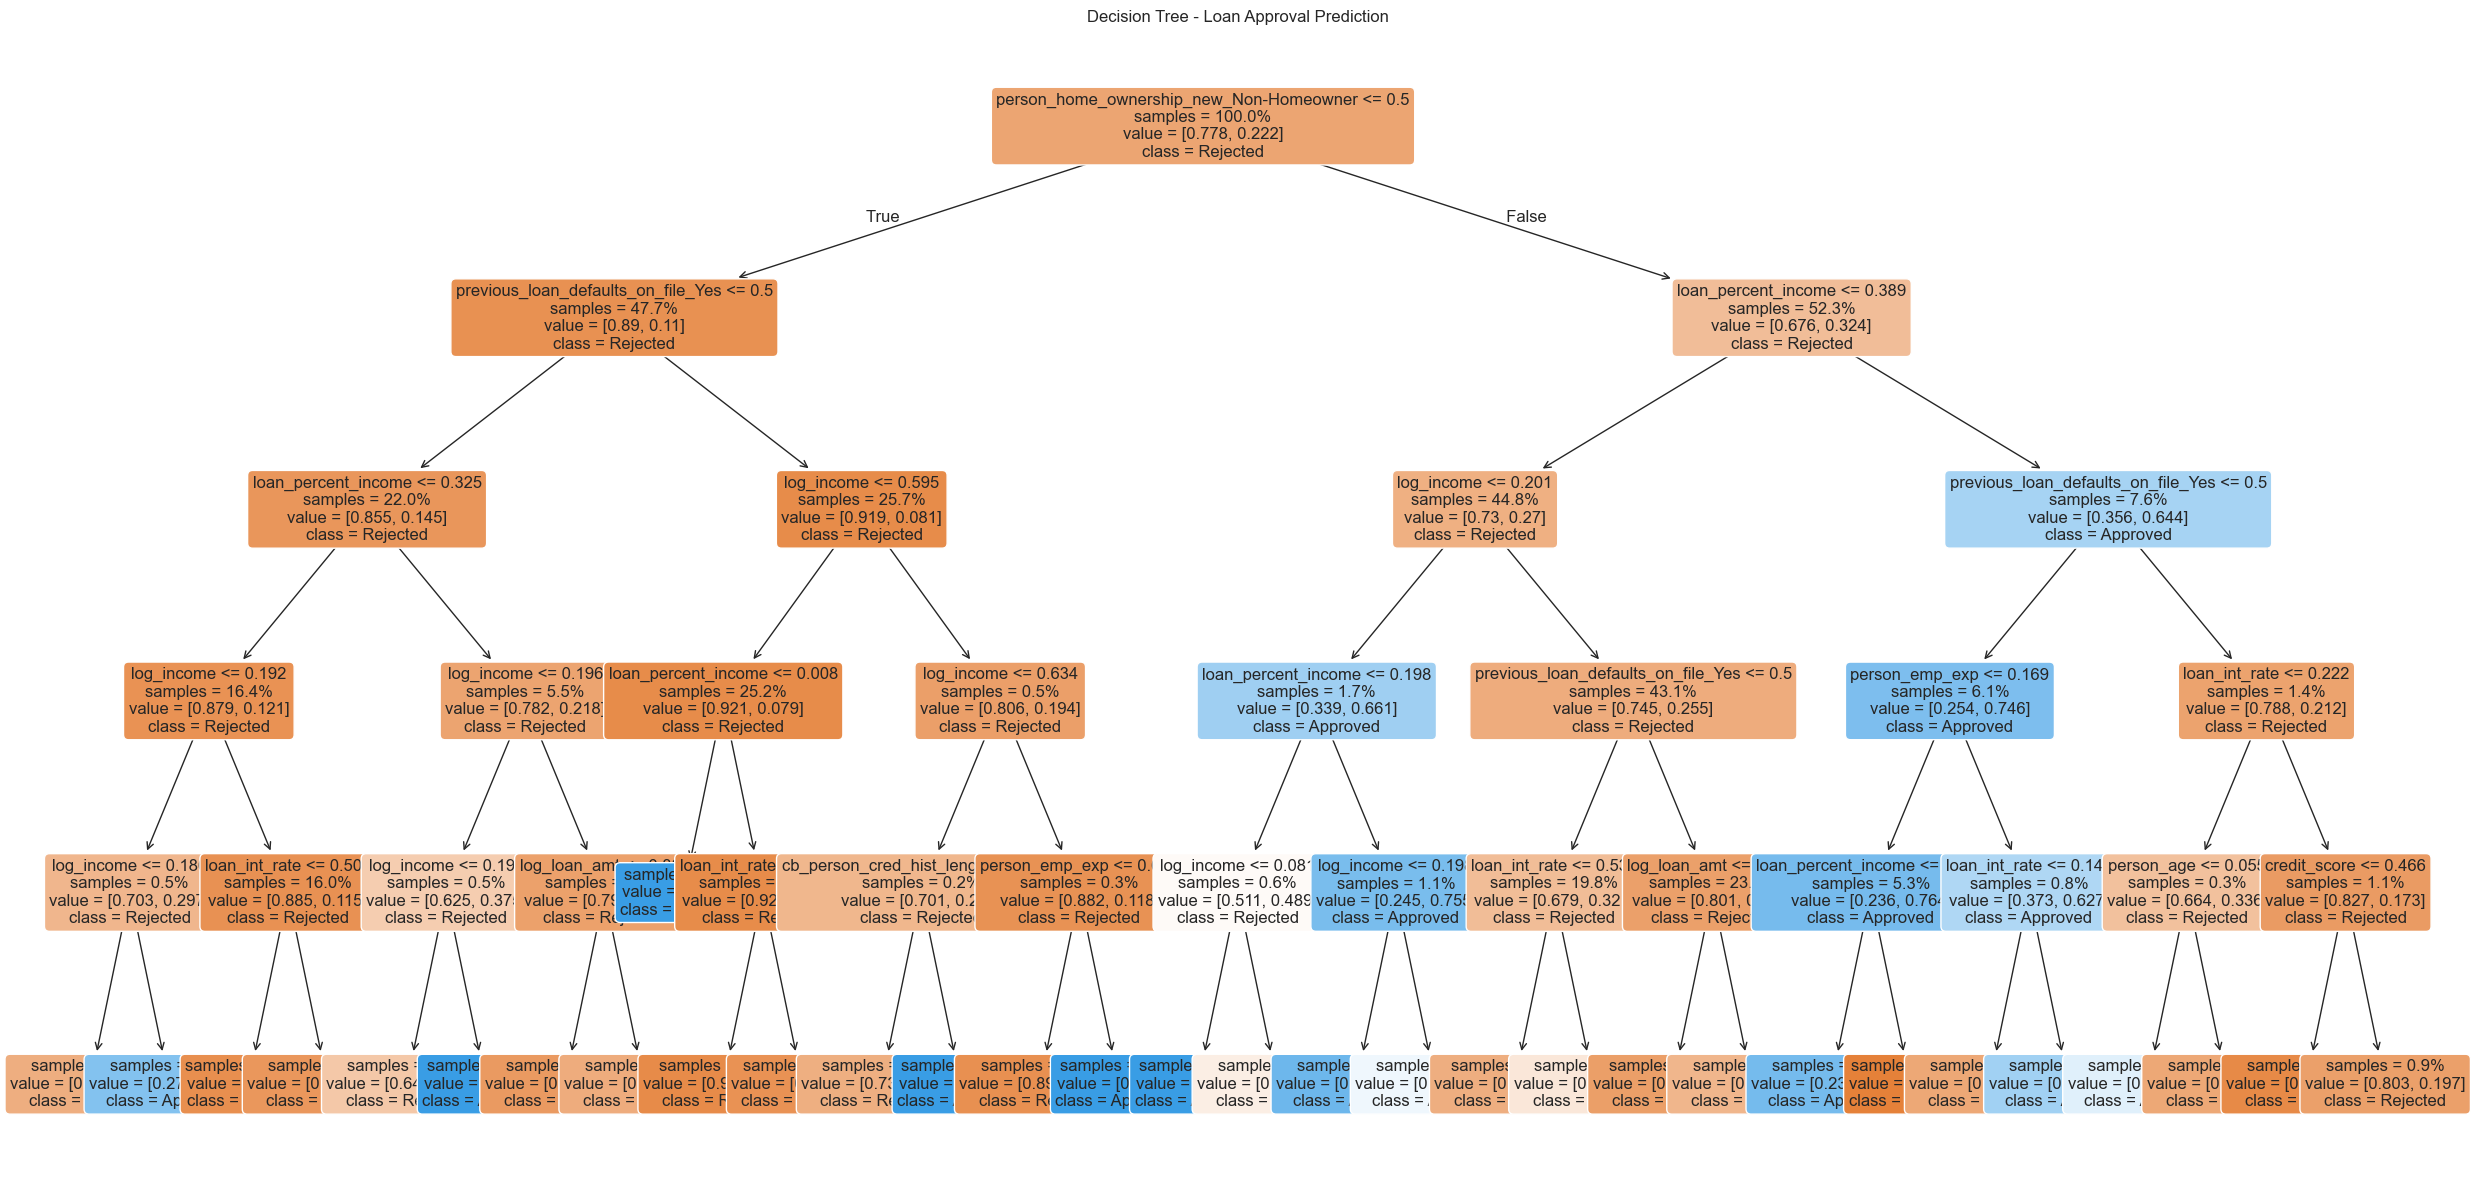

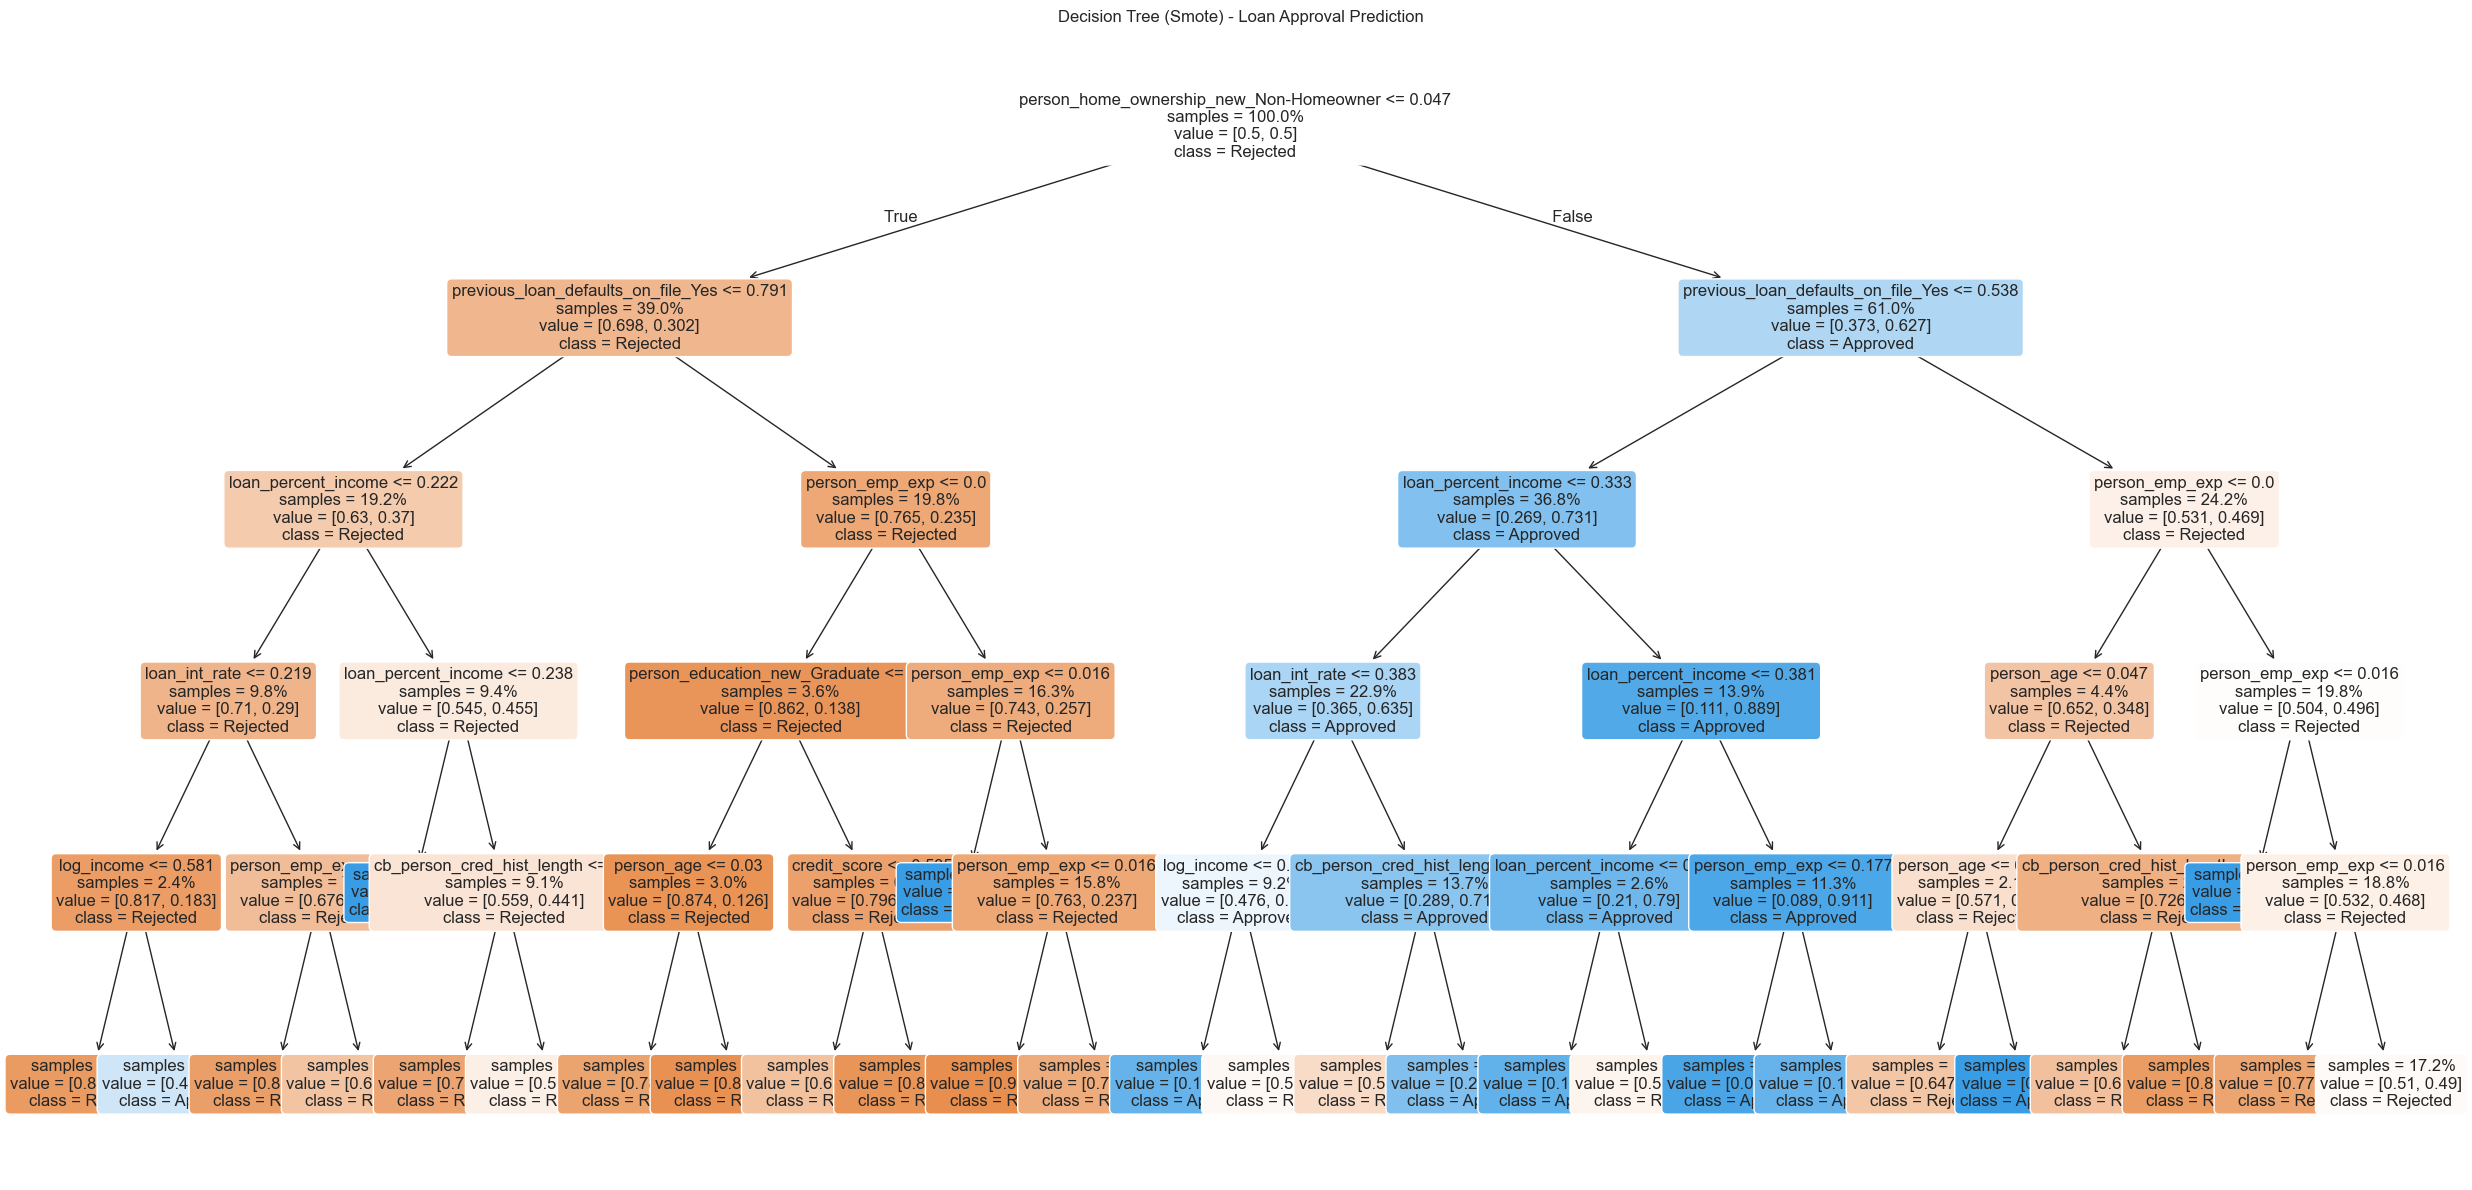

In [46]:
# Decision Tree -- Base Model
dt_model = DecisionTreeClassifier(max_depth=5,random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Visualize the Decision Tree
decisionTree(dt_model, X_train)

# Decision Tree -- Smote Model
smote_dt_model = DecisionTreeClassifier(max_depth=5,random_state=42)
smote_dt_model.fit(X_smote_train, y_smote_train)

# Visualize the Decision Tree
decisionTree(smote_dt_model, X_train, smote=True)


<h3> Model 3: SVM </h3>

In [47]:
# SVM -- Base Model
svmBase = SVC(kernel='rbf', C=10, random_state=42)
svmBase.fit(X_train_scaled, y_train)

# SVM -- Smote Model
svm_smote = SVC(kernel='rbf', C=10, random_state=42)
svm_smote.fit(X_smote_train, y_smote_train)

SVC(C=10, random_state=42)

<h2> Model Evaluation </h2>

<h4> Logistic Regression </h4>

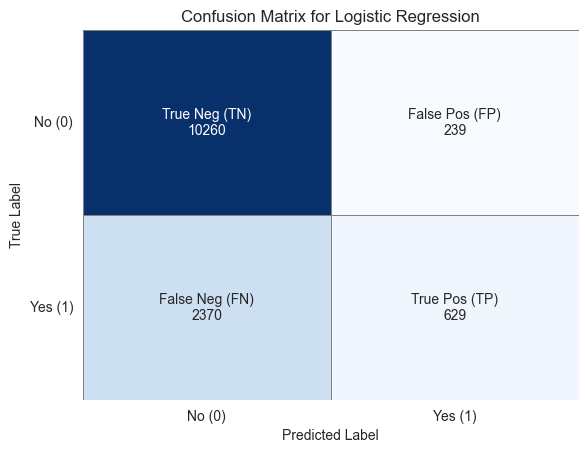


--- Model Evaluation ---
Accuracy Score:  0.8067121054971107
Precision Score:  0.7246543778801844
Recall Score:  0.20973657885961988
F1 Score:  0.3253167830359452
Specificity:  0.9772359272311649
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     10499
           1       0.72      0.21      0.33      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.59      0.61     13498
weighted avg       0.79      0.81      0.76     13498



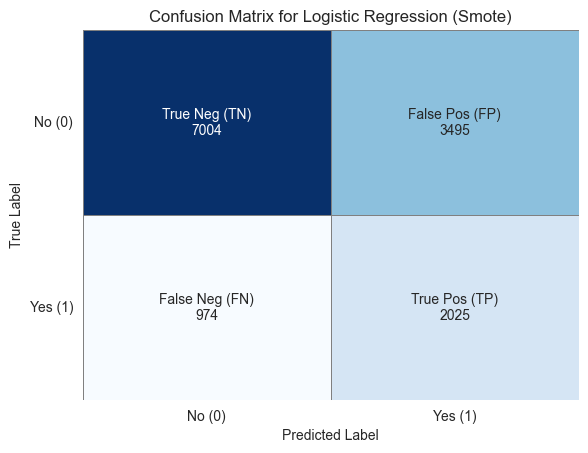


--- Model Evaluation ---
Accuracy Score:  0.6689139131723219
Precision Score:  0.36684782608695654
Recall Score:  0.6752250750250083
F1 Score:  0.47540791172672847
Specificity:  0.6671111534431851
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     10499
           1       0.37      0.68      0.48      2999

    accuracy                           0.67     13498
   macro avg       0.62      0.67      0.62     13498
weighted avg       0.76      0.67      0.70     13498



In [48]:
# Base Model 
lr_pred = lrBase.predict(X_test_scaled)
print(cm(lr_pred, y_test, 'Logistic Regression'))

# Smote Model
lr_smote_pred = lr_smote.predict(X_test_scaled)
print(cm(lr_smote_pred, y_smote_test, 'Logistic Regression', smote=True))


**Logistic Regression Model Evaluation** - The confusion matrix and evaluation metrics above of the Logistic Regression without SMOTE show the performance to predict loan approval status (approved vs. rejected). The model achieves a relatively high accuracy of 81%, but this is somewhat misleading due to class imbalance — there are far more rejected loans (class 0) than approved loans (class 1) as seen above under class distribution. The specificity is very high at 0.98, meaning the model is excellent at correctly identifying rejected loans. However, the recall for approved loans is only 0.21, indicating the model is missing most of the actual approved cases, which could be a serious issue in a loan approval system where it's important not to overlook eligible applicants. The precision is 0.73, showing that when the model does predict a loan as approved, it's correct about 73% of the time. Overall, the model is heavily biased toward predicting rejections.

To address this issue, in the next iteration of the model we applied SMOTE (Synthetic Minority Over-sampling Technique). SMOTE helps balance the dataset by generating synthetic samples of the minority class (approved loans), giving the model a more representative understanding of both outcomes. This is expected to improve recall, allowing the model to better detect approved loans while maintaining a reasonable trade-off with precision and accuracy.

After applying SMOTE, recall improved significantly to 0.68, indicating better sensitivity to approved applications. However, this came at a cost: accuracy dropped to 0.67, precision fell to 0.37, and specificity decreased to 0.67, signaling that the model began approving more ineligible applicants — which poses financial risk to the financial institutions. Given these trade-offs, while SMOTE improved the model’s ability to detect approved loans, it also increased the risk of false approvals.

<h3> Decision Tree </h3>

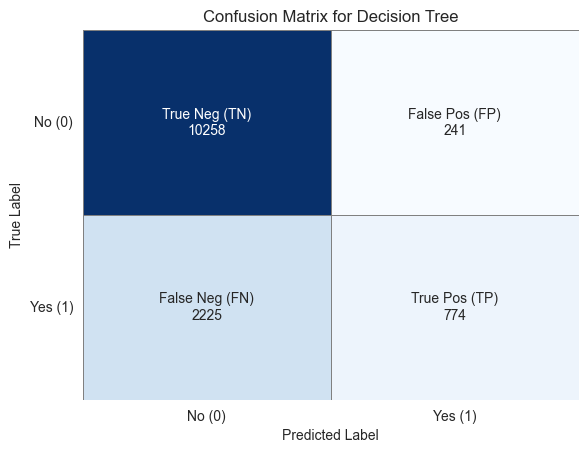


--- Model Evaluation ---
Accuracy Score:  0.8173062675951993
Precision Score:  0.7625615763546798
Recall Score:  0.25808602867622543
F1 Score:  0.38565022421524664
Specificity:  0.9770454328983713
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     10499
           1       0.76      0.26      0.39      2999

    accuracy                           0.82     13498
   macro avg       0.79      0.62      0.64     13498
weighted avg       0.81      0.82      0.78     13498



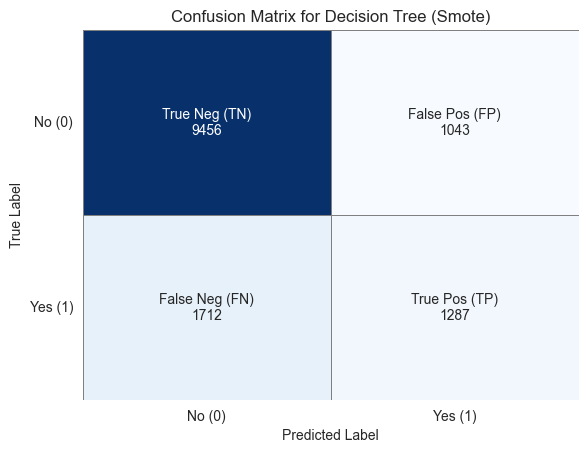


--- Model Evaluation ---
Accuracy Score:  0.7958956882501111
Precision Score:  0.5523605150214592
Recall Score:  0.42914304768256084
F1 Score:  0.48301745167948956
Specificity:  0.9006572054481379
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     10499
           1       0.55      0.43      0.48      2999

    accuracy                           0.80     13498
   macro avg       0.70      0.66      0.68     13498
weighted avg       0.78      0.80      0.79     13498



In [49]:
#Base Model
dt_predictions = dt_model.predict(X_test_scaled)
print(cm(dt_predictions, y_test, 'Decision Tree'))

#Smote Model
smote_dt_predictions = smote_dt_model.predict(X_smote_test)
print(cm(smote_dt_predictions, y_smote_test, 'Decision Tree', smote=True))

**Decision Tree Model Evaluation** - The Decision Tree model without SMOTE demonstrates strong performance in predicting the "Rejected" class, with a precision of 0.82 and an exceptionally high recall of 0.97, leading to a solid f1-score of 0.89. This indicates that the model is very good at correctly identifying rejected loan applications. However, its performance on the "Approved" class is much weaker, with a precision of 0.74 but a low recall of 0.27 and an f1-score of only 0.39. This shows that the model struggles to correctly identify approved loans, often misclassifying them as rejections. Although the overall accuracy is 82%, it is heavily biased toward the majority "Rejected" class. The macro averages, particularly a recall of 0.62 and an f1-score of 0.64, highlight this imbalance, suggesting the model is not equally effective for both classes.

Similar to the Logistic Regression Model, to overcome the imbalance and improve model's performance, SMOTE was applied to the response variable. The Decision Tree model trained after applying SMOTE shows a significant improvement in identifying Approved loan applications, increasing recall from 0.27 to 0.54 — meaning the model now correctly captures more than half of the actual approvals. The f1-score for the Approved class also improved from 0.39 to 0.49, indicating a more balanced trade-off between precision and recall. However, this gain comes at the cost of overall accuracy, which dropped from 82% to 74%, and a lower recall for the Rejected class (0.97 → 0.80), meaning the model now misclassifies more rejections as approvals.

<h3> SVM </h3>

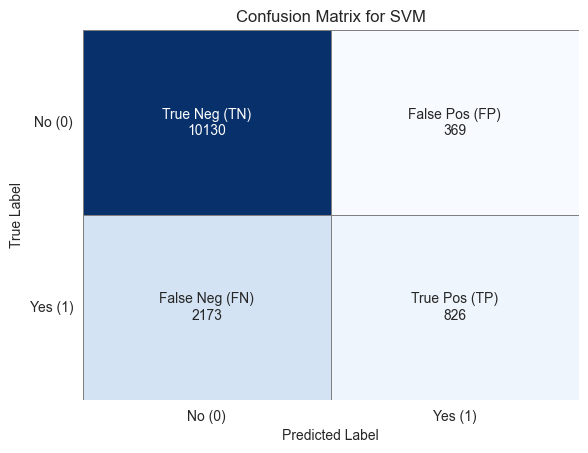


--- Model Evaluation ---
Accuracy Score:  0.8116758038227886
Precision Score:  0.6912133891213389
Recall Score:  0.27542514171390464
F1 Score:  0.3938960419647115
Specificity:  0.964853795599581
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     10499
           1       0.69      0.28      0.39      2999

    accuracy                           0.81     13498
   macro avg       0.76      0.62      0.64     13498
weighted avg       0.79      0.81      0.78     13498



In [50]:
# Base Model
svm_pred = svmBase.predict(X_test_scaled)
print(cm(svm_pred, y_test, 'SVM'))

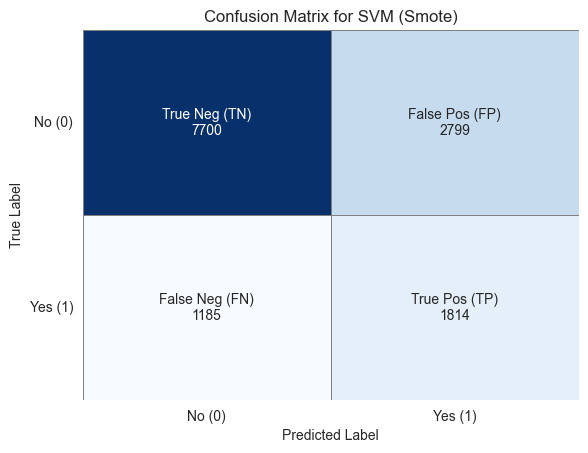


--- Model Evaluation ---
Accuracy Score:  0.7048451622462587
Precision Score:  0.39323650552785605
Recall Score:  0.60486828942981
F1 Score:  0.4766158696794535
Specificity:  0.7334031812553576
              precision    recall  f1-score   support

           0       0.87      0.73      0.79     10499
           1       0.39      0.60      0.48      2999

    accuracy                           0.70     13498
   macro avg       0.63      0.67      0.64     13498
weighted avg       0.76      0.70      0.72     13498



In [51]:
# Smote Model
svm_pred_smote = svm_smote.predict(X_smote_test)
print(cm(svm_pred_smote, y_smote_test, 'SVM', smote=True))

**SVM Model Evaluation** - Without SMOTE, the model achieves a high accuracy of 81.17% and strong performance on the majority class (class 0), with a precision of 0.82, recall of 0.96, and an F1-score of 0.89. However, it struggles significantly with the minority class (class 1), achieving only a 0.28 recall and an F1-score of 0.39, indicating poor sensitivity and potential bias toward the majority class. After applying SMOTE, the model becomes more balanced in its performance across both classes. While overall accuracy drops to 70.48%, the recall for the minority class improves to 0.6%, and the F1-score rises to 0.48. This improvement comes at the cost of a lower specificity (73.34% vs. 96.49%) and reduced precision for class 1 (from 0.69 to 0.39), reflecting more false positives. In summary, SMOTE enhances the model’s ability to identify the minority class at the expense of overall accuracy and precision similar to the previous 2 models. 

<h2> Hyper Parameter Tuning </h2>

To further improve the performance of our models, we applied hyperparameter tuning to ensure that our models are not limited by default settings, which is not be suitable for the imbalance in our response variable in our dataset. By finding the optimal parameters, tuning can lead to improvements in key performance metrics like accuracy, recall, precision, and F1-score. This is especially important for our dataset, where a well-tuned model can better identify minority class instances without sacrificing too much overall performance. Moreover, tuning helps the model generalize better to unseen data, reducing the risks of overfitting or underfitting. 

<h3> Logistic Regression </h3>


Logistic Regression Best Parameters: {'C': np.float64(2.782559402207126), 'penalty': 'l1', 'solver': 'liblinear'}


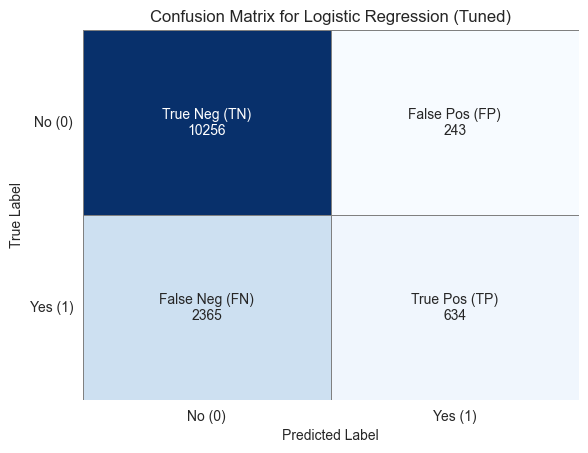


--- Model Evaluation ---
Accuracy Score:  0.8067861905467477
Precision Score:  0.7229190421892816
Recall Score:  0.21140380126708902
F1 Score:  0.32714138286893707
Specificity:  0.9768549385655777
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     10499
           1       0.72      0.21      0.33      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.59      0.61     13498
weighted avg       0.79      0.81      0.76     13498


Logistic Regression (Smote) Best Parameters: {'C': np.float64(0.0001), 'penalty': 'l2', 'solver': 'liblinear'}


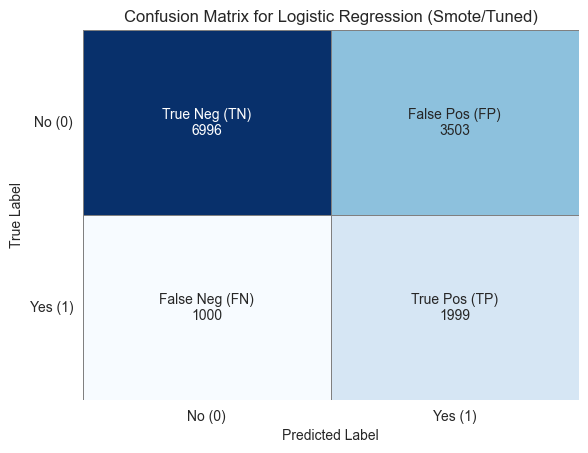


--- Model Evaluation ---
Accuracy Score:  0.6663950214846643
Precision Score:  0.3633224282079244
Recall Score:  0.6665555185061687
F1 Score:  0.4702976120456417
Specificity:  0.6663491761120107
              precision    recall  f1-score   support

           0       0.87      0.67      0.76     10499
           1       0.36      0.67      0.47      2999

    accuracy                           0.67     13498
   macro avg       0.62      0.67      0.61     13498
weighted avg       0.76      0.67      0.69     13498



In [52]:
# ---- Logistic Regression - Tuning ----
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
lr_grid_search.fit(X_train_scaled, y_train)

print("\nLogistic Regression Best Parameters:", lr_grid_search.best_params_)
lr_best_model = lr_grid_search.best_estimator_

#Generate the predictions
lr_tuned_predictions = lr_best_model.predict(X_test_scaled)

#Evaluate the model
print(cm(lr_tuned_predictions, y_test, 'Logistic Regression', tuned=True))

# ---- Logistic Regression - Tuning with SMOTE ----
lr_grid_search_smote = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
lr_grid_search_smote.fit(X_smote_train, y_smote_train)

print("\nLogistic Regression (Smote) Best Parameters:", lr_grid_search_smote.best_params_)
lr_best_model_smote = lr_grid_search_smote.best_estimator_

#Generate the predictions
lr_tuned_predictions_smote = lr_best_model_smote.predict(X_smote_test)

#Evaluate the model
print(cm(lr_tuned_predictions_smote, y_test, 'Logistic Regression', tuned=True, smote=True))

The tuned Logistic Regression model achieved an overall accuracy of 81%, performing very well at identifying rejected loans (98% recall) but struggling with approved ones, capturing only 21% of them. While the precision for approved loans is relatively decent at 72%, the low recall suggests many approved cases are being misclassified as rejected. This leads to a lower F1-score of 0.33 for the approved class. The macro average recall is 0.59, highlighting the imbalance in performance between classes. 

On the other hand, the tuned Logistic Regression model, trained with SMOTE, achieves an overall accuracy of approximately 66.6%. While it performs the best in terms of recall for the minority class (Approved loans) at 66.7%, its precision for approvals is relatively low at 36.3%, indicating that many predicted approvals are incorrect. The model correctly identifies rejected loans 66.6% of the time (specificity) but struggles with a high number of false positives. The F1-score for the approved class is moderate at 0.47, reflecting the imbalance between precision and recall. Overall, while the model is effective and doing the best at capturing most approvals amongst all the previous models, it sacrifices precision, leading to a higher risk of incorrectly approving ineligible applications. 

<h3> Decision Tree </h3>


Decision Tree Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}


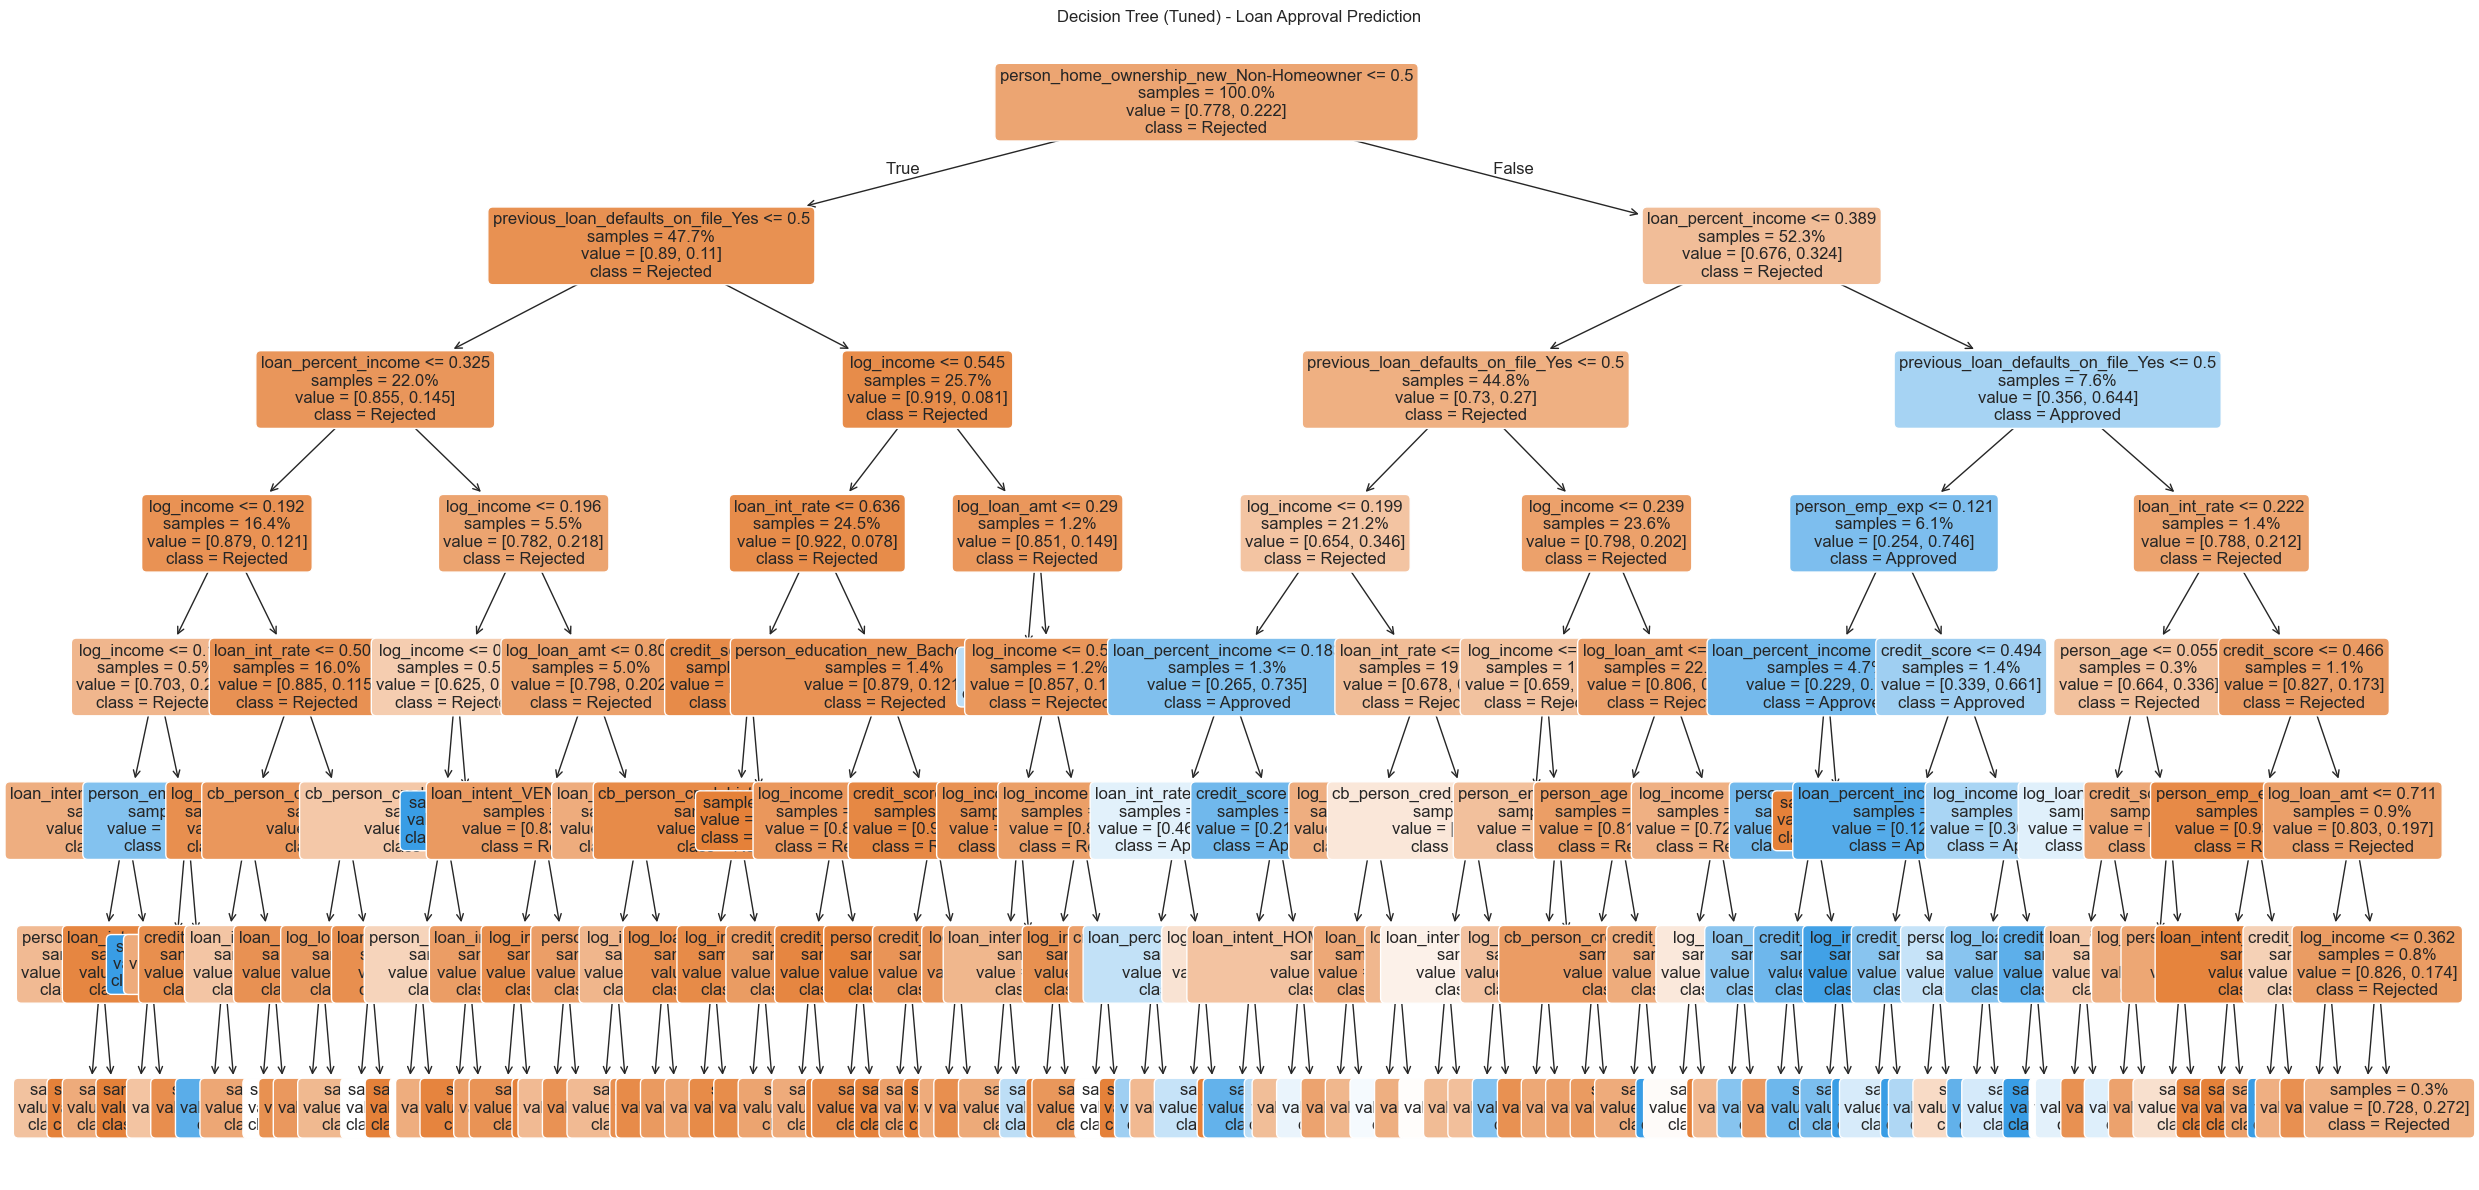

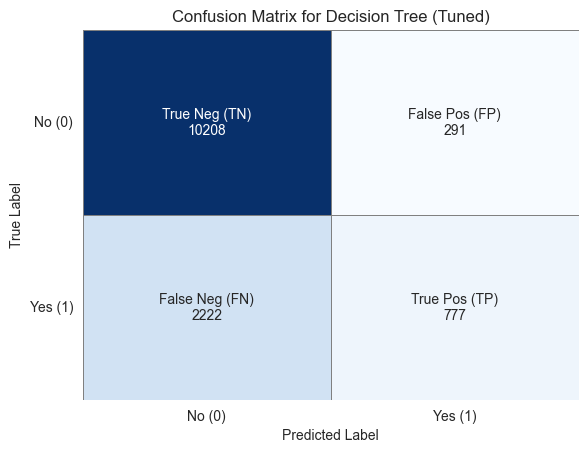


--- Model Evaluation ---
Accuracy Score:  0.8138242702622611
Precision Score:  0.7275280898876404
Recall Score:  0.2590863621207069
F1 Score:  0.38209982788296043
Specificity:  0.9722830745785312
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10499
           1       0.73      0.26      0.38      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.62      0.64     13498
weighted avg       0.80      0.81      0.78     13498


Decision Tree(Smote) Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}


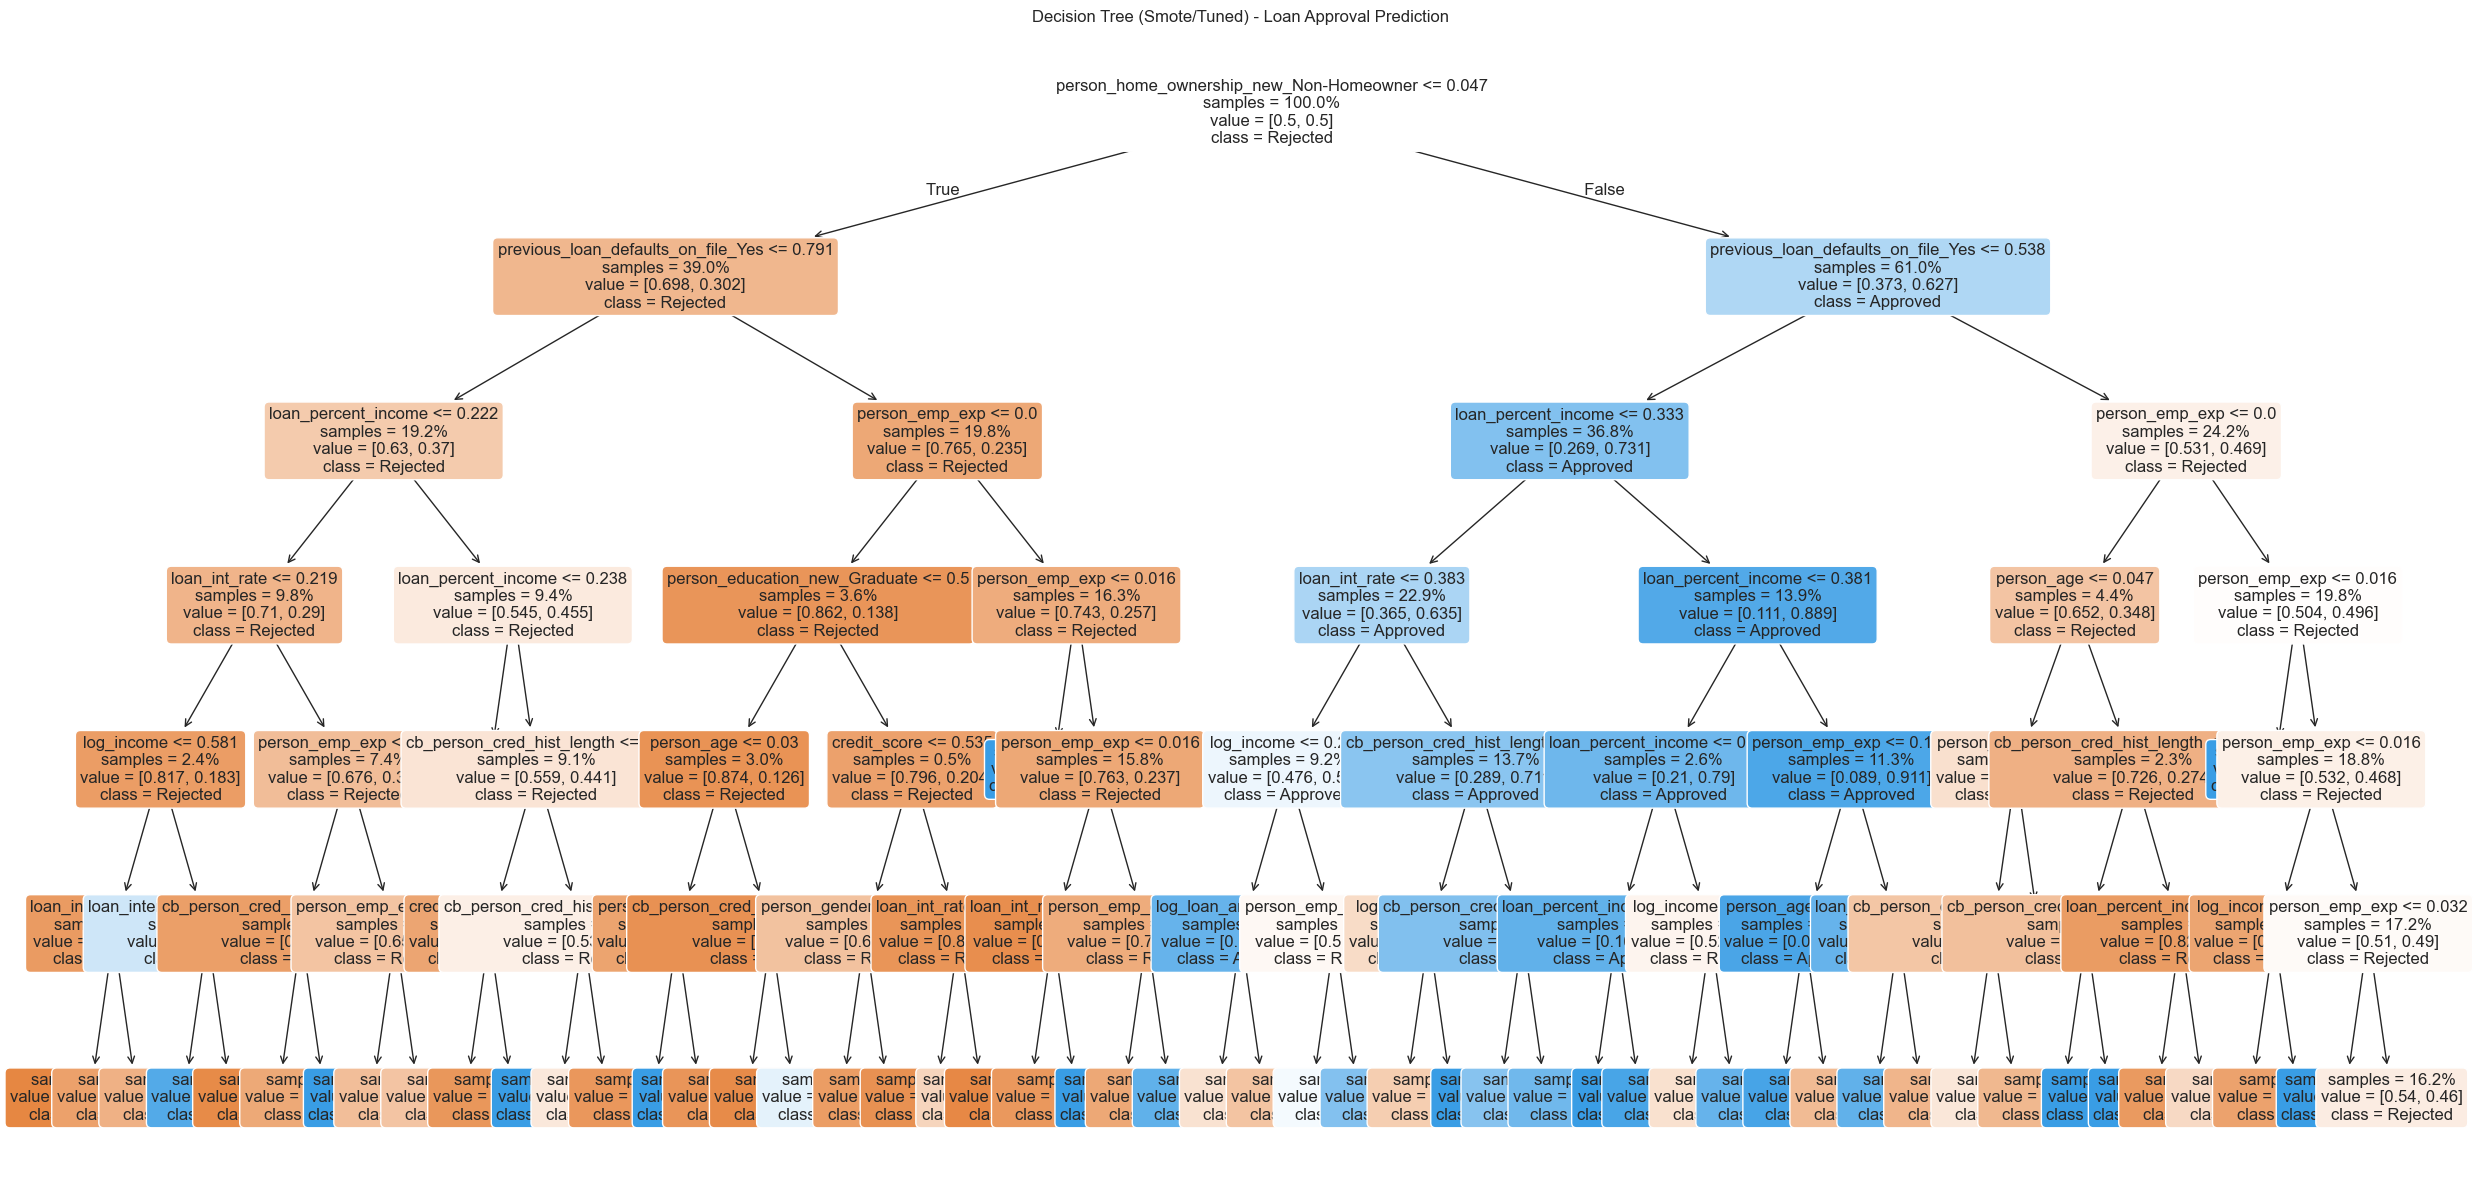

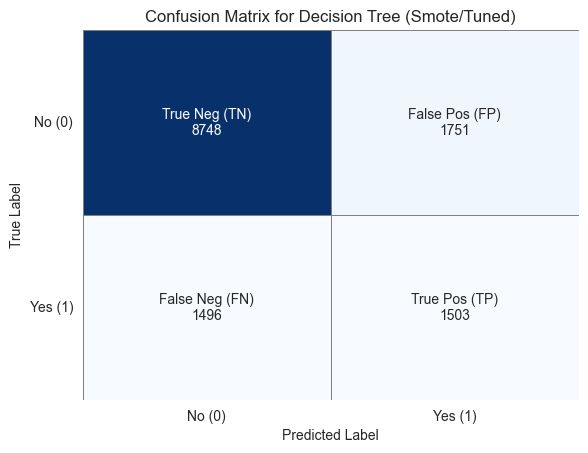


--- Model Evaluation ---
Accuracy Score:  0.7594458438287154
Precision Score:  0.46189305470190534
Recall Score:  0.5011670556852285
F1 Score:  0.4807292499600192
Specificity:  0.8332222116392037
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     10499
           1       0.46      0.50      0.48      2999

    accuracy                           0.76     13498
   macro avg       0.66      0.67      0.66     13498
weighted avg       0.77      0.76      0.76     13498



In [53]:
# ---- Decision Tree - Tuning ----
dt_grid_search = GridSearchCV(DecisionTreeClassifier(max_depth=5,random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid_search.fit(X_train_scaled, y_train)
print("\nDecision Tree Best Parameters:", dt_grid_search.best_params_)

dt_best_model = dt_grid_search.best_estimator_

# Visualize the Decision Tree
decisionTree(dt_best_model, X_train, tuned=True)

# Generate the predictions 
dt_pred_tuned = dt_best_model.predict(X_test_scaled)

#Evaluate the model
print(cm(dt_pred_tuned, y_test, 'Decision Tree', tuned=True))

# --- Decision Tree - Tuning with SMOTE ---
dt_grid_search_smote = GridSearchCV(DecisionTreeClassifier(max_depth=5,random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid_search_smote.fit(X_smote_train, y_smote_train)
print("\nDecision Tree(Smote) Best Parameters:", dt_grid_search_smote.best_params_)

dt_best_model_smote = dt_grid_search_smote.best_estimator_

# Visualize the Decision Tree
decisionTree(dt_best_model_smote, X_train, tuned=True, smote=True)

# Generate the predictions
dt_pred_smote = dt_best_model_smote.predict(X_smote_test)

# Evaluate the model
print(cm(dt_pred_smote, y_smote_test, 'Decision Tree', tuned=True, smote=True))

The tuned Decision Tree model indicate strong performance on the majority class but continued struggles with the minority class. For the "Rejected" class (class 0), the model achieves high precision (0.83), recall (0.96), and F1-score (0.89), showing that it accurately and consistently identifies rejected cases. However, the model performs poorly on the "Approved" class (class 1), with a lower precision of 0.67 and a recall of just 0.31, leading to an F1-score of 0.43. This means the model misses a large portion of actual approved cases. While the overall accuracy is relatively high at 81%, and the weighted F1-score is 0.79, these are influenced heavily by the imbalanced dataset where rejected cases dominate. The macro-average F1-score, which gives equal weight to both classes, is only 0.66, highlighting the imbalance in performance. Compared to the results of the Decision Tree Model (SMOTE) without tuning, this model with tuning has a lower recall.

The SMOTE Tuned Decision Tree model shows a moderate improvement in balancing the performance between the two classes compared to both the untuned and non-SMOTE versions. For the majority class (Rejected), the model maintains strong performance with a precision of 0.84, recall of 0.87, and F1-score of 0.85. For the minority class (Approved), the precision improves to 0.48, and recall reaches 0.42, with an F1-score of 0.45 — higher than the original tuned model (F1 = 0.43) and slightly below the SMOTE-only model (F1 = 0.49). Overall accuracy is 77%, which is a middle ground between the higher accuracy of the tuned non-SMOTE model (81%) and the lower accuracy of the SMOTE-only version (74%). The macro average F1-score of 0.65 and the weighted average F1 of 0.76 reflect a more balanced performance across both classes. This suggests that applying both SMOTE and hyperparameter tuning helps reduce class imbalance effects, offering a better trade-off between precision and recall for the minority class, while preserving respectable accuracy and majority class performance.

<h3> SVM </h3>


 SVM Best Parameters: {'C': 10, 'kernel': 'rbf'}


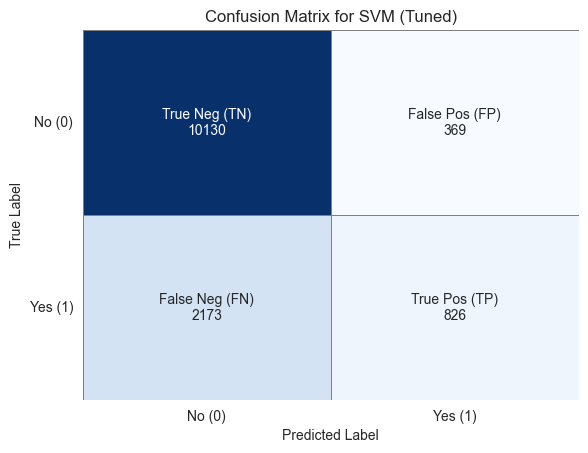


--- Model Evaluation ---
Accuracy Score:  0.8116758038227886
Precision Score:  0.6912133891213389
Recall Score:  0.27542514171390464
F1 Score:  0.3938960419647115
Specificity:  0.964853795599581
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     10499
           1       0.69      0.28      0.39      2999

    accuracy                           0.81     13498
   macro avg       0.76      0.62      0.64     13498
weighted avg       0.79      0.81      0.78     13498


 SVM (Smote) Best Parameters: {'C': 10, 'kernel': 'rbf'}


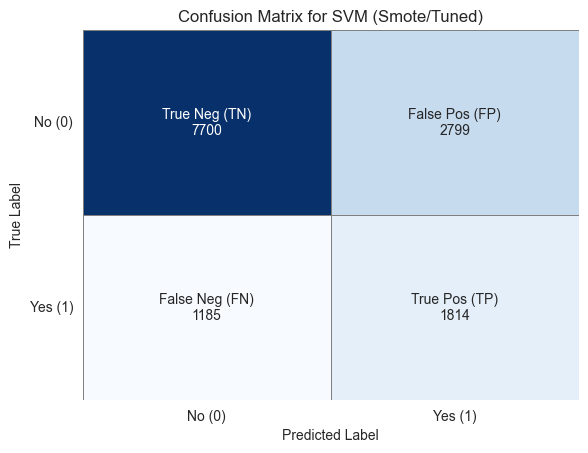


--- Model Evaluation ---
Accuracy Score:  0.7048451622462587
Precision Score:  0.39323650552785605
Recall Score:  0.60486828942981
F1 Score:  0.4766158696794535
Specificity:  0.7334031812553576
              precision    recall  f1-score   support

           0       0.87      0.73      0.79     10499
           1       0.39      0.60      0.48      2999

    accuracy                           0.70     13498
   macro avg       0.63      0.67      0.64     13498
weighted avg       0.76      0.70      0.72     13498



In [54]:
# ---- SVM - Tuning ----
svm_grid_search =  GridSearchCV(SVC(random_state=42),
                               param_grid=svm_param_grid, cv=5, scoring='f1', n_jobs=-1)
svm_grid_search.fit(X_train_scaled, y_train)

# Print out the best parameters
print("\n SVM Best Parameters:", svm_grid_search.best_params_)
svm_best_model = svm_grid_search.best_estimator_

# Generate the predictions
svm_tuned_pred = svm_best_model.predict(X_test_scaled)

# Evaluate the model
print(cm(svm_tuned_pred, y_test, 'SVM', tuned=True))

# ---- SVM - Tuning with smote ----
# Create GridSearchCV
svm_grid_search_smote =  GridSearchCV(SVC(random_state=42),
                               param_grid=svm_param_grid, cv=5, scoring='f1', n_jobs=-1)
svm_grid_search_smote.fit(X_smote_train, y_smote_train)

#Print out the best parameters
print("\n SVM (Smote) Best Parameters:", svm_grid_search_smote.best_params_)

svm_best_model_smote = svm_grid_search_smote.best_estimator_

# Generate the predictions
svm_tuned_smote_pred = svm_best_model_smote.predict(X_smote_test)

#Evaluate the model
print(cm(svm_tuned_smote_pred, y_smote_test, 'SVM', tuned=True, smote=True))

After hyperparameter tuning, the SVM model without SMOTE maintains a high accuracy of 81.17% and excellent performance on the majority class (class 0), with a recall of 96% and F1-score of 0.89. However, its recall for the minority class (class 1) remains low at 0.28, indicating that despite tuning, the model still struggles to correctly identify positive instances. On the other hand, when SMOTE is applied to the tuned model, the recall for class 1 significantly improves to 0.6, and the F1-score increases to 0.48, highlighting a more balanced model performance. This improvement comes at the cost of reduced accuracy (70.48%) and specificity (73.34%), due to a higher rate of false positives. Overall, tuning combined with SMOTE helps the model become more sensitive to the minority class but increases the chances of false positives.

Additionally, based on our hyperparameter tuning, we can see that our original base and smote models were using the best parameters, so we will continue to use those models for SVM.

<h2> Cross-Validation </h2>

<h3> Logistic Regression </h3>

In [55]:
# Cross-validation for Logistic Regression
lr_cv_scores = cross_val_score(lrBase,
                               X_train_scaled, y_train, cv=5, scoring='f1')

# Cross-validation for Logistic Regression with smote
lr_cv_scores_smote = cross_val_score(lr_smote,
                                     X_smote_train, y_smote_train, cv=5, scoring='f1')

#Cross-validation for tuned Logistic Regression
lr_cv_best_model_scores = cross_val_score(lr_best_model,
                                          X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for tuned Logistic Regression with smote
lr_cv_best_model_scores_smote = cross_val_score(lr_best_model_smote,
                                                X_smote_train, y_smote_train, cv=5, scoring='f1')

print("Logistic Regression Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV F1 Score':<20}")
print(f"{'Original':<20}{lr_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{lr_cv_scores_smote.mean():<20.4f}")
print(f"{'Tuned':<20}{lr_cv_best_model_scores.mean():<20.4f}")
print(f"{'Tuned + SMOTE':<20}{lr_cv_best_model_scores_smote.mean():<20.4f}")

Logistic Regression Cross-Validation Comparison:
Dataset             Mean CV F1 Score    
Original            0.3246              
SMOTE               0.6690              
Tuned               0.3259              
Tuned + SMOTE       0.6718              


<h3> Decision Tree </h3>

In [56]:
# Cross-validation for Decision Tree
dt_cv_scores = cross_val_score(dt_model,
                                X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for Decision Tree with smote
dt_cv_smote_scores = cross_val_score(smote_dt_model,
                                X_smote_train, y_smote_train, cv=5, scoring='f1')

#Cross-validation for tuned Decision Tree
dt_cv_best_model_scores = cross_val_score(dt_best_model,
                                X_train_scaled, y_train, cv=5, scoring='f1')

# Cross-validation for tuned Decision Tree with smote
dt_cv_smote_best_model_scores = cross_val_score(dt_best_model_smote,
                                X_smote_train, y_smote_train, cv=5, scoring='f1')

print("Decision Tree Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV F1 Score':<20}")
print(f"{'Original':<20}{dt_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{dt_cv_smote_scores.mean():<20.4f}")
print(f"{'Tuned':<20}{dt_cv_best_model_scores.mean():<20.4f}")
print(f"{'Tuned + SMOTE':<20}{dt_cv_smote_best_model_scores.mean():<20.4f}")



Decision Tree Cross-Validation Comparison:
Dataset             Mean CV F1 Score    
Original            0.3669              
SMOTE               0.6376              
Tuned               0.4199              
Tuned + SMOTE       0.6727              


<h3> SVM </h3>

In [57]:
#Cross-validation for SVM
svm_cv_scores = cross_val_score(svmBase,
                                X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for SVM with smote
svm_cv_scores_smote = cross_val_score(svm_smote,
                                X_smote_train, y_smote_train, cv=5, scoring='f1')
"""
#Cross-validation for tuned SVM
svm_cv_best_model_scores = cross_val_score(svm_best_model,
                                X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for SVM with smote
svm_cv_best_model_smote_scores = cross_val_score(svm_best_model_smote,
                                X_smote_train, y_smote_train, cv=5, scoring='f1')
"""

print("SVM Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV F1 Score':<20}")
print(f"{'Original/Tuned':<20}{svm_cv_scores.mean():<20.4f}")
print(f"{'SMOTE/Tuned':<20}{svm_cv_scores_smote.mean():<20.4f}")
#print(f"{'Tuned':<20}{svm_cv_best_model_scores.mean():<20.4f}")
#print(f"{'Tuned + SMOTE':<20}{svm_cv_best_model_smote_scores.mean():<20.4f}")

SVM Cross-Validation Comparison:
Dataset             Mean CV F1 Score    
Original/Tuned      0.3858              
SMOTE/Tuned         0.6916              


Based on the cross-validation results, it is clear that the best-performing models across all three algorithms—Logistic Regression, Decision Tree, and SVM—are those that have been both balanced using SMOTE and fine-tuned through hyperparameter optimization. These models consistently achieve the highest mean cross-validated F1 scores, with Logistic Regression reaching 0.6718, Decision Tree at 0.6727, and SVM at 0.6916. This indicates that the combination of SMOTE and tuning significantly enhances the models’ ability to correctly classify the minority class, leading to a more balanced and effective performance. Given these findings, we will now proceed to compare the tuned and SMOTE-applied models in more detail to determine the overall best-performing model.

<h2> Model Comparison </h2>

--- Logistic Regression ---


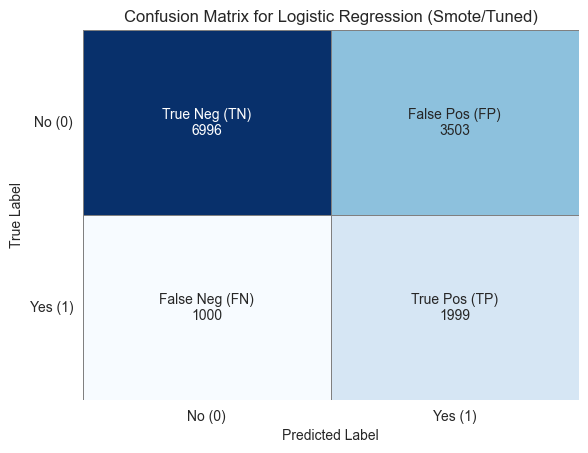


--- Model Evaluation ---
Accuracy Score:  0.6663950214846643
Precision Score:  0.3633224282079244
Recall Score:  0.6665555185061687
F1 Score:  0.4702976120456417
Specificity:  0.6663491761120107
              precision    recall  f1-score   support

           0       0.87      0.67      0.76     10499
           1       0.36      0.67      0.47      2999

    accuracy                           0.67     13498
   macro avg       0.62      0.67      0.61     13498
weighted avg       0.76      0.67      0.69     13498

--- Decision Tree ---


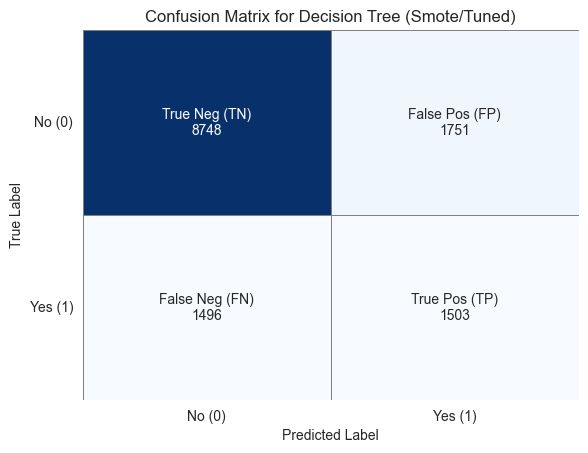


--- Model Evaluation ---
Accuracy Score:  0.7594458438287154
Precision Score:  0.46189305470190534
Recall Score:  0.5011670556852285
F1 Score:  0.4807292499600192
Specificity:  0.8332222116392037
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     10499
           1       0.46      0.50      0.48      2999

    accuracy                           0.76     13498
   macro avg       0.66      0.67      0.66     13498
weighted avg       0.77      0.76      0.76     13498

--- SVM ---


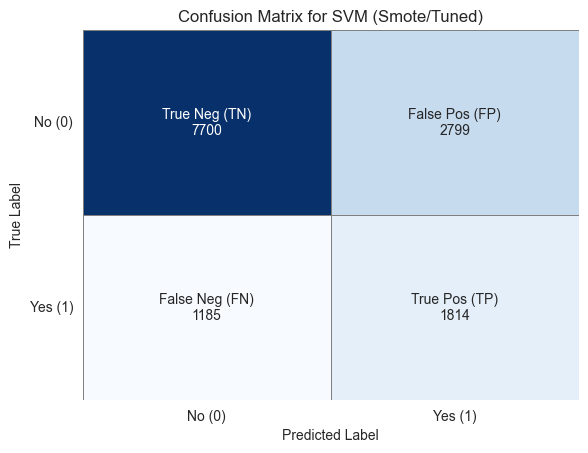


--- Model Evaluation ---
Accuracy Score:  0.7048451622462587
Precision Score:  0.39323650552785605
Recall Score:  0.60486828942981
F1 Score:  0.4766158696794535
Specificity:  0.7334031812553576
              precision    recall  f1-score   support

           0       0.87      0.73      0.79     10499
           1       0.39      0.60      0.48      2999

    accuracy                           0.70     13498
   macro avg       0.63      0.67      0.64     13498
weighted avg       0.76      0.70      0.72     13498



In [58]:
# --- Confusion Matrices ---
# Plot confusion matrices for the three models

# Logistic Regression 
print("--- Logistic Regression ---")
print(cm(lr_tuned_predictions_smote, y_test, 'Logistic Regression', tuned=True, smote=True))

# Decision Tree
print("--- Decision Tree ---")
print(cm(dt_pred_smote, y_smote_test, 'Decision Tree', tuned=True, smote=True))

# SVM
print("--- SVM ---")
print(cm(svm_pred_smote, y_smote_test, 'SVM', tuned=True, smote=True))


In [59]:
# Logistic Regression
lr_scores = cm_Scores(lr_tuned_predictions_smote, y_smote_test, confusion_matrix(lr_tuned_predictions_smote, y_smote_test))

# Decision Tree
dt_scores = cm_Scores(dt_pred_smote, y_smote_test, confusion_matrix(dt_pred_smote, y_smote_test))


# SVM
svm_scores = cm_Scores(svm_pred_smote, y_smote_test, confusion_matrix(svm_pred_smote, y_smote_test))

#Combine all of the scores into one
scores_compare = pd.concat([lr_scores, dt_scores, svm_scores])

new_index = ['Logistic Regression', 'Decision Tree', 'SVM']
scores_compare.index = new_index

print(scores_compare)

                     Accuracy Score  Precision Score  Recall Score  F1 Score  \
Logistic Regression        0.666395         0.363322      0.666556  0.470298   
Decision Tree              0.759446         0.461893      0.501167  0.480729   
SVM                        0.704845         0.393237      0.604868  0.476616   

                     Specificity  
Logistic Regression     0.874937  
Decision Tree           0.853963  
SVM                     0.866629  



--- Learning Curve ---


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\user\AppData\Loca

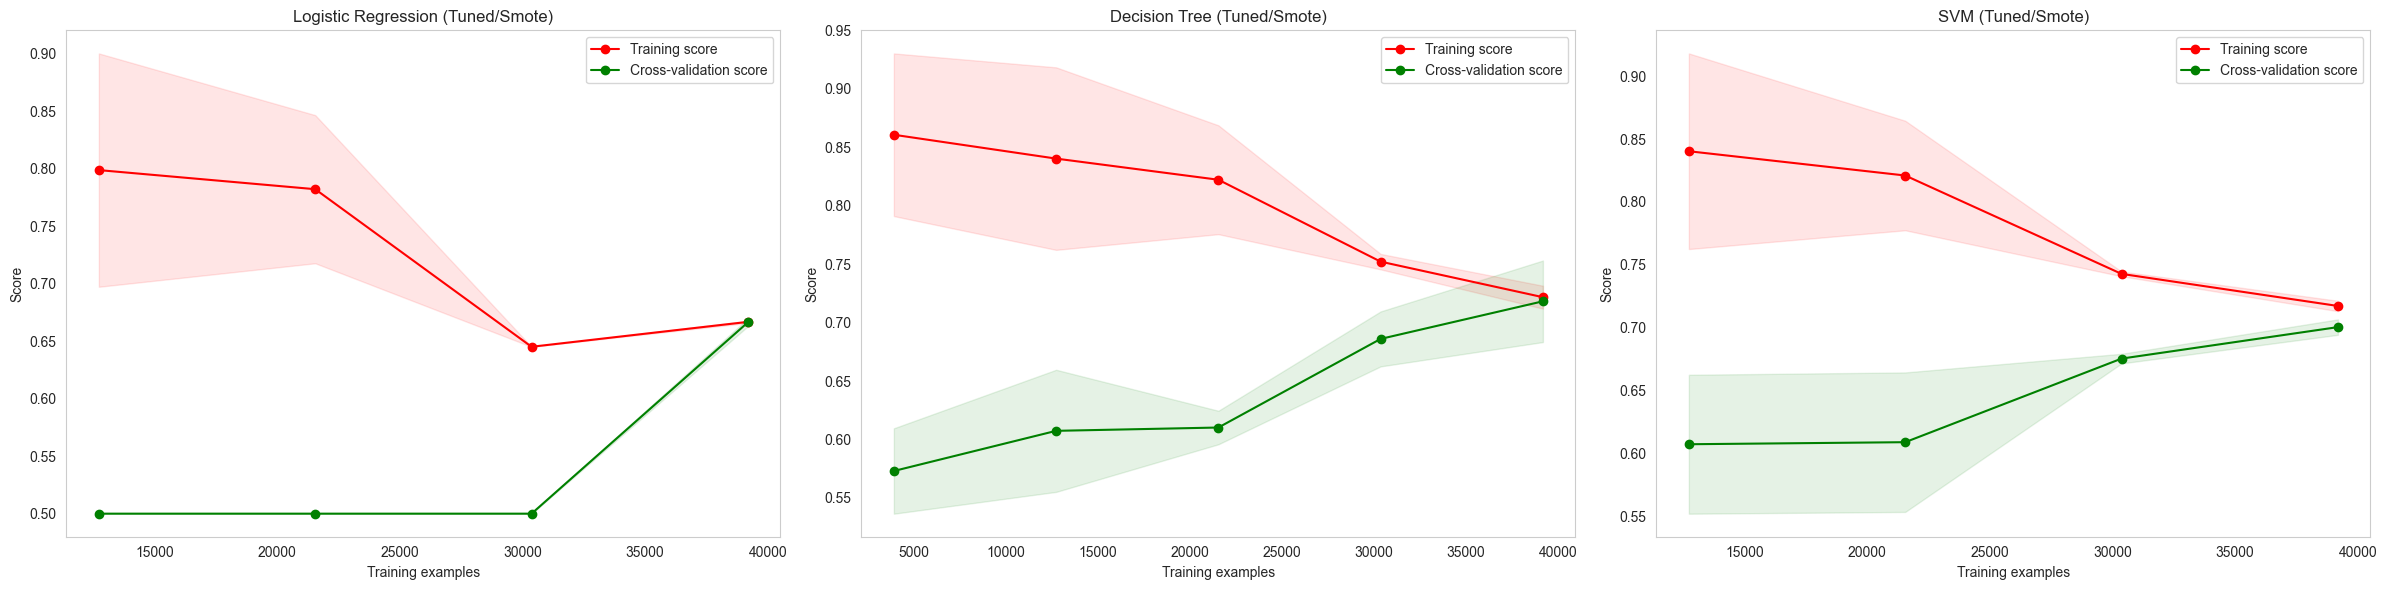

In [60]:
# --- Learning Curve ---
print("\n--- Learning Curve ---")
# Plot learning curves for different models
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
# Logistic Regression
plot_learning_curve(lr_best_model_smote,
                    "Logistic Regression (Tuned/Smote)",  
                    X_smote_train, y_smote_train, axes=axes[0], cv=5)

# Decision Tree
plot_learning_curve(dt_best_model_smote,
                    "Decision Tree (Tuned/Smote)", 
                    X_smote_train, y_smote_train, axes=axes[1], cv=5)

# SVM
plot_learning_curve(svm_smote,
                    "SVM (Tuned/Smote)", 
                    X_smote_train, y_smote_train, axes=axes[2], cv=5)
plt.tight_layout()
plt.show()

<h2> Conclusion </h2>

Based on the evaluation metrics of the tuned models with SMOTE, the Decision Tree model demonstrates the best overall performance among the three. It achieves the highest accuracy (75.94%), the highest precision (46.19%), and the highest F1 score (0.4807), indicating a strong balance between precision and recall. Additionally, it has the highest specificity (83.32%), meaning it performs well in correctly identifying negative cases.

While the Logistic Regression model shows the highest recall at 0.66, which reflects its ability to detect the minority class, it does so at the cost of lower precision, accuracy, and specificity. The SVM model performs moderately across all metrics, with a recall of 0.6% and an F1 score of 0.4766, but it falls short of the Decision Tree in terms of overall balance.

However, the learning curves of both the Decision Tree and Logistic Regression models exhibit a noticeable gap between training and cross-validation scores, especially with smaller training sets. Although the gap narrows as the amount of training data increases, the Decision Tree model still shows signs of mild overfitting — the training score remains consistently higher than the cross-validation score. In contrast, Logistic Regression, while underfitting slightly, demonstrates a more consistent and stable learning curve trend as the data size grows.

This suggests that while the tuned Decision Tree with SMOTE currently offers the best evaluated performance, caution should be exercised when utilizing it, especially if new unseen data is expected to differ from the training distribution.

In conclusion, despite slight overfitting tendencies observed in the learning curves, the tuned Decision Tree with SMOTE remains the best-performing and most balanced model among those compared — but future improvements could further enhance its generalizability.

<h2> PDP Plots </h2>

In [61]:
X.columns

Index(['person_age', 'person_emp_exp', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score', 'log_income',
       'log_loan_amt', 'person_gender_male', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'previous_loan_defaults_on_file_Yes', 'person_education_new_Bachelor',
       'person_education_new_Graduate', 'person_education_new_High School',
       'person_home_ownership_new_Non-Homeowner'],
      dtype='object')

<h4> Numeric Variables </h4>

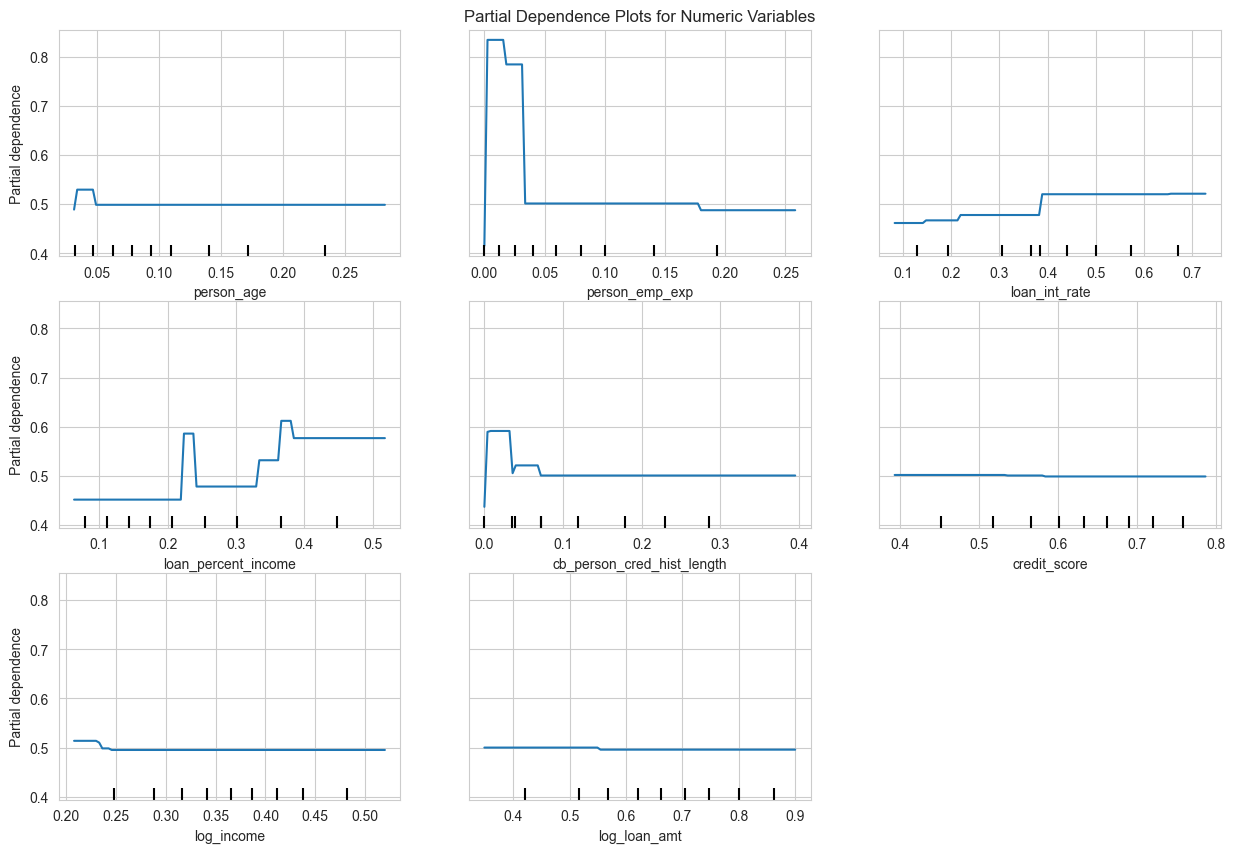

In [62]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Partial Dependence Plots for Numeric Variables")
PartialDependenceDisplay.from_estimator(
    estimator=dt_best_model_smote,
    features= (0,1,2,3,4,5,6,7),
    feature_names=X.columns,
    X=X_smote_train,
    random_state=5,
    ax=ax,
)
plt.show()

The Partial Dependence Plots (PDPs) reveal that most numeric features in the model have only a limited effect on the predicted outcome. Person employment experience (person_emp_exp) and loan percent income (loan_percent_income) show some noticeable influence: low employment experience tends to slightly increase the predicted risk, and higher loan-to-income ratios also correlate with higher risk. Loan interest rate (loan_int_rate) has a mild positive impact, where higher rates slightly increase risk predictions. On the other hand, features such as person age, credit score, income (log_income), loan amount (log_loan_amt), and credit history length (cb_person_cred_hist_length) show almost flat lines, suggesting they have very little independent effect on the model's decisions. Overall, while a few variables do show some influence, the model’s predictions seem relatively insensitive to most individual numeric features.

<h4> Binary Variables with Two Classes </h4>

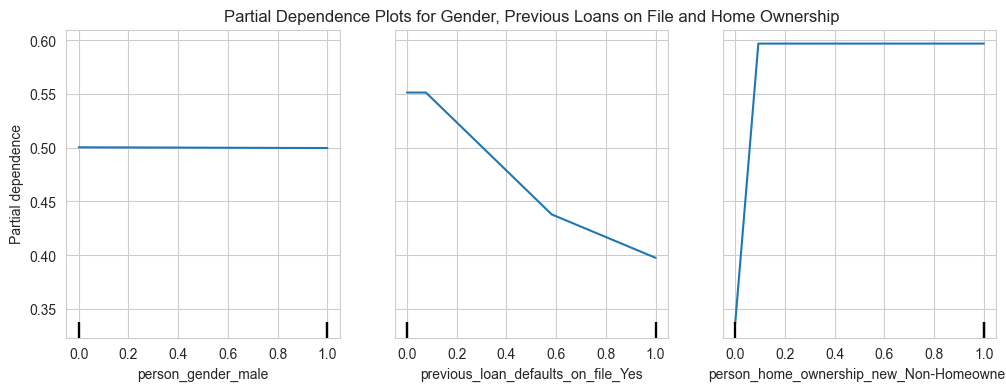

In [63]:
fig, ax = plt.subplots(figsize=(12,4))
ax.set_title("Partial Dependence Plots for Gender, Previous Loans on File and Home Ownership")
PartialDependenceDisplay.from_estimator(
    estimator=dt_best_model_smote,
    features= (8,14, 18),
    feature_names=X.columns,
    X=X_smote_train,
    random_state=5,
    ax=ax,
)
plt.show()

These PDP plots show how three categorical features impact the model’s predictions. Gender (person_gender_male) has no visible effect — the flat line indicates that being male or female doesn't change the prediction. Previous loan defaults (previous_loan_defaults_on_file_Yes) show a clear negative trend: individuals with defaults are associated with a lower partial dependence, suggesting they are less likely to get a favorable prediction. Home ownership (person_home_ownership_new_Non-Homeowner) has a sharp effect — non-homeowners have much higher partial dependence, meaning the model predicts them very differently compared to homeowners.

<h4> Loan Intent </h4>

In [2]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Partial Dependence Plots for Loan Intent Categories")
PartialDependenceDisplay.from_estimator(
    estimator=dt_best_model_smote,
    features= (9,10,11,12,13),
    feature_names=X.columns,
    X=X_smote_train,
    random_state=5,
    ax=ax,
)
plt.show()

NameError: name 'plt' is not defined

The above PDP plots show how that except for education, none of the other factors of loan_intent has any visible effect — the flat lines indicate no impact on the model prediction. However, loan_intent_EDUCATION show a clear positive trend: individuals who's intent for the loan is education are associated with higher partial dependence, suggesting they are more likely to get a favorable prediction.

<h4> Education </h4>

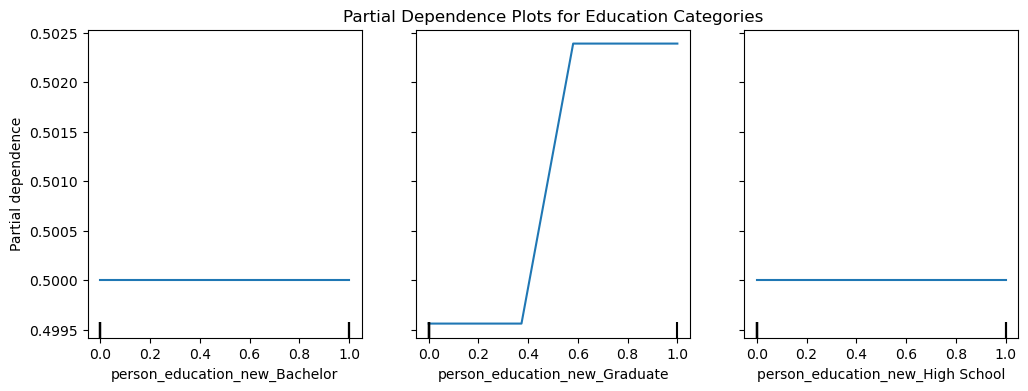

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Partial Dependence Plots for Education Categories")
PartialDependenceDisplay.from_estimator(
    estimator=dt_best_model_smote,
    features= (15,16,17),
    feature_names=X.columns,
    X=X_smote_train,
    random_state=5,
    ax=ax,
)
plt.show()

For individuals with a Bachelor’s degree or a High School education, the partial dependence remains flat at around 0.5, indicating that these categories have little to no influence on the model's predictions. In contrast, the Graduate category shows a slight increase in partial dependence when moving from 0 to 1, suggesting that having a Graduate degree slightly raises the probability of a positive prediction. Overall, only the Graduate education category appears to have a meaningful, though still small, impact on the model's output.